# PPO for Active Suspension System (4-Dim Numerical System)
## Define the dynamic equation

In [ ]:
%reset -f

import numpy as np
import gym
from gym import spaces
import numpy as np
from scipy.linalg import expm
from scipy.integrate import quad_vec

class DynamicSystemEnv(gym.Env):
    def __init__(self):
        # parameters
        self.T = 0.05
        self.kus = 232.5e3
        self.mus = 65
        self.ms = 325
        self.ks = 27692.0
        self.cs = 1906.5
        self.ct = 0
        self.ks_max = 40000
        self.ks_min = 10000
        self.cs_max = 3000
        self.cs_min = 500

        A, B, Gd = self.sys_matrices()
        self.A = A
        self.B = B
        self.Gd = Gd

        # System dynamics parameters
        self.Q = np.array([[10,0,0,0], [0,1,0,0], [0,0,50,0], [0,0,0,5]])     # State cost matrix
        self.R = 0.000001                                 # Action cost
        
        # State and action spaces
        self.observation_space = spaces.Box(low=-2.5, high=2.5, shape=(4,), dtype=np.float32)
        self.action_space = spaces.Box(low=-1000, high=1000, shape=(1,), dtype=np.float32)
        
        # Initial state
        self.state = np.array([-0.1,-1,-0.1,-0.5])
        
        # Maximum episode steps
        self.max_steps = 100
        self.current_step = 0
    
    def sys_matrices(self):
        Ac = np.array([[0,1,0,0], [-self.kus/self.mus,-self.cs/self.mus,self.ks/self.mus,self.cs/self.mus],[0,-1,0,1],[0,self.cs/self.ms,-self.ks/self.ms,-self.cs/self.ms]])
        Bc = np.array([[0],[-1/self.mus],[0],[1/self.ms]])
        Gc = np.array([[-1],[self.ct/self.mus],[0],[0]])
        def funB(t):
            return expm(Ac * t) @ Bc

        def funG(t):
            return expm(Ac * t) @ Gc

        A = expm(Ac * self.T)
        B = quad_vec(funB, 0, self.T)
        B = B[0]
        Gd = quad_vec(funG, 0, self.T)
        Gd = Gd[0]
        return A, B, Gd

    def step(self, action, ks_normalized, cs_normalized):
        ks = ks_normalized*(self.ks_max-self.ks_min)+self.ks_min
        cs = cs_normalized*(self.cs_max-self.cs_min)+self.cs_min
        self.ks = ks
        self.cs = cs

        A, B, Gd = self.sys_matrices()
        self.A = A
        self.B = B
        self.Gd = Gd

        # Clip action to stay within action bounds
        action = np.clip(action, self.action_space.low, self.action_space.high)
        
        # Update state based on system dynamics
        x = self.state
        # x_next = np.dot(self.A, x) + np.dot(self.B, action) is the deterministic part
        x_next = np.dot(self.A, x) + np.dot(self.B, action) + np.dot(self.Gd, np.random.normal(loc=0, scale=0.3, size=(1, )))
        
        
        # Calculate reward      
        reward = -x_next@self.Q@x_next.T - self.R * action**2
                
        # Update state
        self.state = x_next
        
        # Check if done
        done = (self.current_step >= self.max_steps) or (self.state[0]**2+self.state[1]**2+self.state[2]**2+self.state[3]**2<=0.01)
        self.current_step += 1
        
        return self.state, reward[0], done, {}
    
    def step_real(self, action, dzdt, ks_normalized, cs_normalized):
        ks = ks_normalized*(self.ks_max-self.ks_min)+self.ks_min
        cs = cs_normalized*(self.cs_max-self.cs_min)+self.cs_min
        self.ks = ks
        self.cs = cs
        knl = 0.01*ks # nonlinear term of spring coefficient
        cnl = 0.01*cs # nonlinear term of damping coefficient

        A, B, Gd = self.sys_matrices()
        self.A = A
        self.B = B
        self.Gd = Gd

        # Clip action to stay within action bounds
        action = np.clip(action, self.action_space.low, self.action_space.high)
        
        # Update state based on system dynamics
        x = self.state
        x_next = np.dot(self.A, x) + np.dot(self.B, action) + np.dot(self.Gd, dzdt) \
            + np.array([0,-1/self.mus*(knl*x[2]**3+cnl*abs(x[3]-x[1])*(x[3]-x[1])),0,-1/self.ms*(knl*x[2]**3+cnl*abs(x[3]-x[1])*(x[3]-x[1]))])

        # Calculate reward
        reward = -x_next@self.Q@x_next.T - self.R * action**2
                
        # Update state
        self.state = x_next
        
        # Check if done
        done = (self.current_step >= self.max_steps) or (self.state[0]**2+self.state[1]**2+self.state[2]**2+self.state[3]**2<=0.01)
        self.current_step += 1
        
        return self.state, reward[0], done, {}
    
    def reset(self,ks_normalized,cs_normalized):
        # Reset state to initial value
        ks = ks_normalized*(self.ks_max-self.ks_min)+self.ks_min
        cs = cs_normalized*(self.cs_max-self.cs_min)+self.cs_min
        self.ks = ks
        self.cs = cs
        A, B, Gd = self.sys_matrices()
        self.A = A
        self.B = B
        self.Gd = Gd
        self.state = np.array([-0.1,-1,-0.1,-0.5])
        self.current_step = 0
        return self.state
    
    def reset_origin(self,ks_normalized,cs_normalized):
        # Reset state to the origin
        ks = ks_normalized*(self.ks_max-self.ks_min)+self.ks_min
        cs = cs_normalized*(self.cs_max-self.cs_min)+self.cs_min
        self.ks = ks
        self.cs = cs
        A, B, Gd = self.sys_matrices()
        self.A = A
        self.B = B
        self.Gd = Gd
        self.state = np.array([0.0, 0.0, 0.0, 0.0])
        self.current_step = 0
        return self.state
    
    def render(self, mode='human'):
        pass

    def close(self):
        pass

## Test the system

In [121]:
import matplotlib.pyplot as plt

env = DynamicSystemEnv()
ks = 27692.0
ks_normalized = (ks-env.ks_min)/(env.ks_max-env.ks_min)
cs = 1906.5
cs_normalized = (cs-env.cs_min)/(env.cs_max-env.cs_min)
s = env.reset(ks_normalized,cs_normalized)

K = np.array([[7.092740795835493e+03,-12.619893117381602,1.327338611165778e+03,-9.462992790543780e+02]])
x_sys = np.zeros((4,101))
x_sys[:,0] = s
for i in range(100):
    a = np.dot(K,s)[0]
    s_prime, r, done, _ = env.step(a,ks_normalized,cs_normalized)
    x_sys[:,i+1] = s_prime
    print("Current state:[{:.3f},{:.3f},{:.3f},{:.3f}], Action: {:.3f}, Next state:[{:.3f},{:.3f},{:.3f},{:.3f}]".format(s[0],s[1],s[2],s[3],a,s_prime[0],s_prime[1],s_prime[2],s_prime[3]))
    s = s_prime


Current state:[-0.100,-1.000,-0.100,-0.500], Action: -356.238, Next state:[0.018,0.988,-0.214,0.782]
Current state:[0.018,0.988,-0.214,0.782], Action: -909.814, Next state:[-0.026,0.195,-0.144,1.008]
Current state:[-0.026,0.195,-0.144,1.008], Action: -1331.230, Next state:[0.007,0.348,-0.124,1.313]
Current state:[0.007,0.348,-0.124,1.313], Action: -1361.552, Next state:[0.007,-0.353,-0.049,1.100]
Current state:[0.007,-0.353,-0.049,1.100], Action: -1054.212, Next state:[0.005,0.681,-0.016,0.860]
Current state:[0.005,0.681,-0.016,0.860], Action: -806.819, Next state:[0.013,-0.321,0.016,0.566]
Current state:[0.013,-0.321,0.016,0.566], Action: -420.387, Next state:[0.010,-0.208,0.049,0.160]
Current state:[0.010,-0.208,0.049,0.160], Action: -12.265, Next state:[0.003,0.181,0.052,-0.085]
Current state:[0.003,0.181,0.052,-0.085], Action: 169.599, Next state:[0.010,-0.734,0.057,-0.310]
Current state:[0.010,-0.734,0.057,-0.310], Action: 452.770, Next state:[-0.005,0.378,0.047,-0.431]
Current st

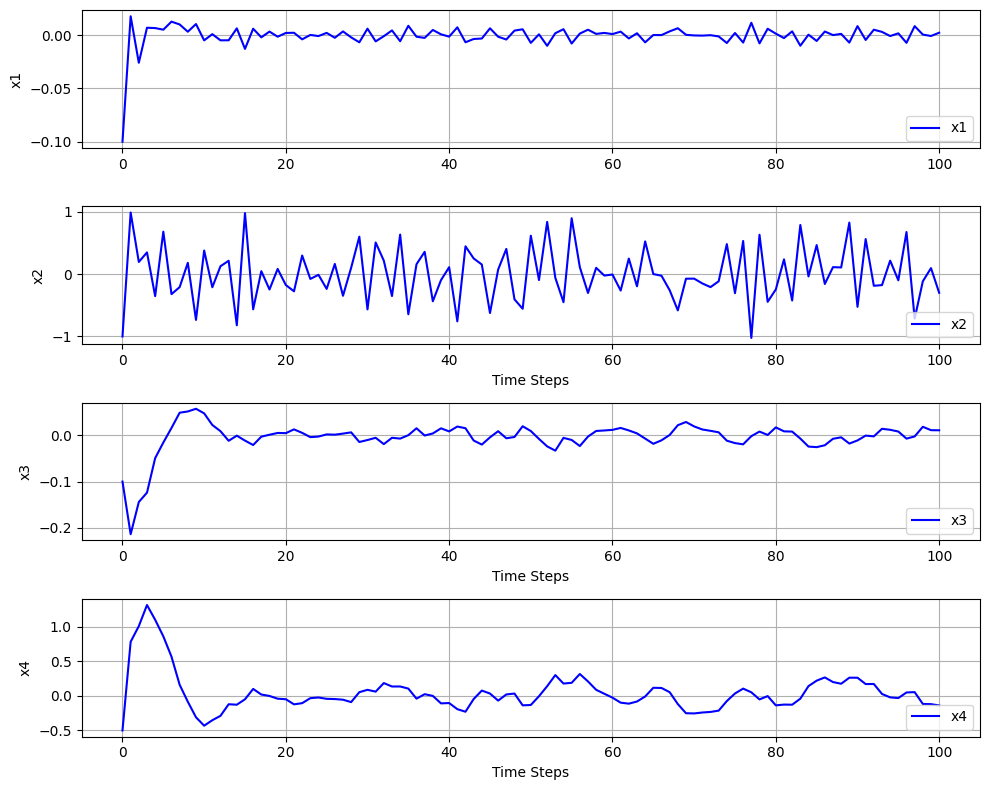

In [122]:
t_vec = np.arange(0, 101)

# Create the mean trajectories with 95% confidence interval
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8))
ax1.plot(t_vec, x_sys[0,:], color='b', label='x1')
# ax1.set_xlabel('Time Steps')
ax1.set_ylabel('x1')
# ax1.set_ylim((-3.75,1.0))
ax1.legend(loc='lower right')
ax1.grid(True)

ax2.plot(t_vec, x_sys[1,:], color='b', label='x2')
ax2.set_xlabel('Time Steps')
ax2.set_ylabel('x2')
# ax2.set_ylim((-4,2))
ax2.legend(loc='lower right')
ax2.grid(True)


ax3.plot(t_vec, x_sys[2,:], color='b', label='x3')
ax3.set_xlabel('Time Steps')
ax3.set_ylabel('x3')
# ax3.set_ylim((-4,2))
ax3.legend(loc='lower right')
ax3.grid(True)

ax4.plot(t_vec, x_sys[3,:], color='b', label='x4')
ax4.set_xlabel('Time Steps')
ax4.set_ylabel('x4')
# ax4.set_ylim((-4,2))
ax4.legend(loc='lower right')
ax4.grid(True)

plt.tight_layout()
plt.show()

In [123]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal

In [124]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"

try:

    # Run on single GPU

    DEVICE_ID = 0

    os.environ["CUDA_VISIBLE_DEVICES"] = str(DEVICE_ID)

    os.system("clear")

except:

    # Run on CPU

    os.system("clear")

    print("No GPU found.")

# Train the initial policy
Using the data based the method by Chen et al. (2018): sampling on the feasible state space, getting the LQR solution with the projection
Reference: https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html

In [125]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

df = pd.read_csv('Data_susp_CCD2.csv')

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(6, 16),
            nn.Tanh(),
            nn.Linear(16, 32),
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 16),
            nn.Tanh(),
            nn.Linear(16, 1),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


Using cuda device


In [126]:
lb_x = [-0.25,-2.5,-0.5,-2.5,env.ks_min,env.cs_min]; ub_x = [0.25,2.5,0.5,2.5,env.ks_max,env.cs_max]
model_initial = NeuralNetwork().to(device)
data = np.array(df)
input_data = data[:,0:6]
normalized_input_data = (input_data - np.min(input_data, axis=0, keepdims=True)) / (np.max(input_data, axis=0, keepdims=True) - np.min(input_data, axis=0, keepdims=True))
output_data = data[:,6]/1000

In [127]:
# Convert data to PyTorch tensors
inputs = torch.tensor(normalized_input_data, dtype=torch.float32).to(device)
targets = torch.tensor(output_data, dtype=torch.float32).reshape(-1, 1)
targets = targets.to(device)

criterion = nn.MSELoss()  # Mean Squared Error loss
optimizer = torch.optim.SGD(model_initial.parameters(), lr=0.01)  # Stochastic Gradient Descent optimizer

num_epochs = 1000
batch_size = 64

for epoch in range(num_epochs):
    for i in range(0, len(input_data), batch_size):
        inputs_batch = inputs[i:i+batch_size]
        # Forward pass
        outputs = model_initial(inputs_batch)
        targets_batch = targets[i:i+batch_size]
        loss = criterion(outputs, targets_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # Print progress
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [100/1000], Loss: 0.1024
Epoch [200/1000], Loss: 0.0680
Epoch [300/1000], Loss: 0.0188
Epoch [400/1000], Loss: 0.0097
Epoch [500/1000], Loss: 0.0079
Epoch [600/1000], Loss: 0.0073
Epoch [700/1000], Loss: 0.0070
Epoch [800/1000], Loss: 0.0067
Epoch [900/1000], Loss: 0.0064
Epoch [1000/1000], Loss: 0.0062


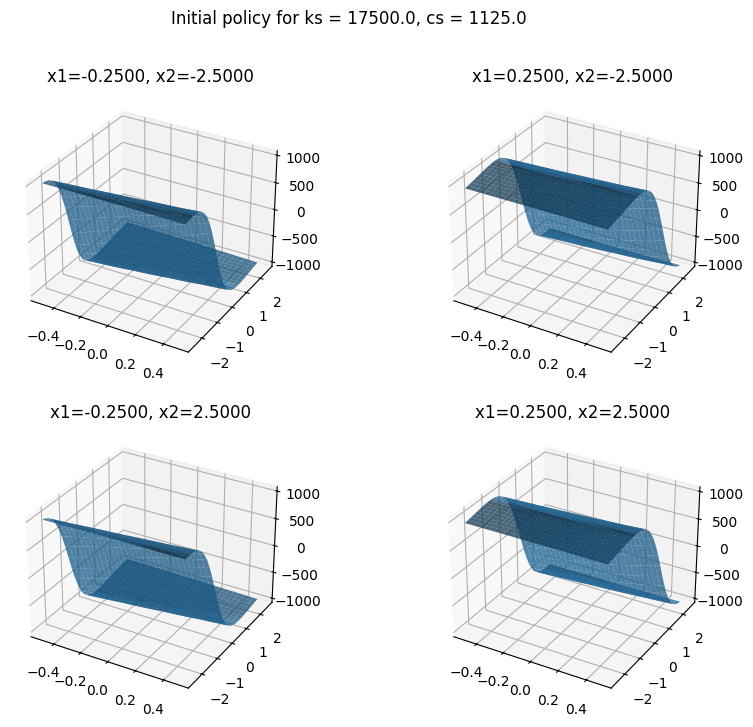

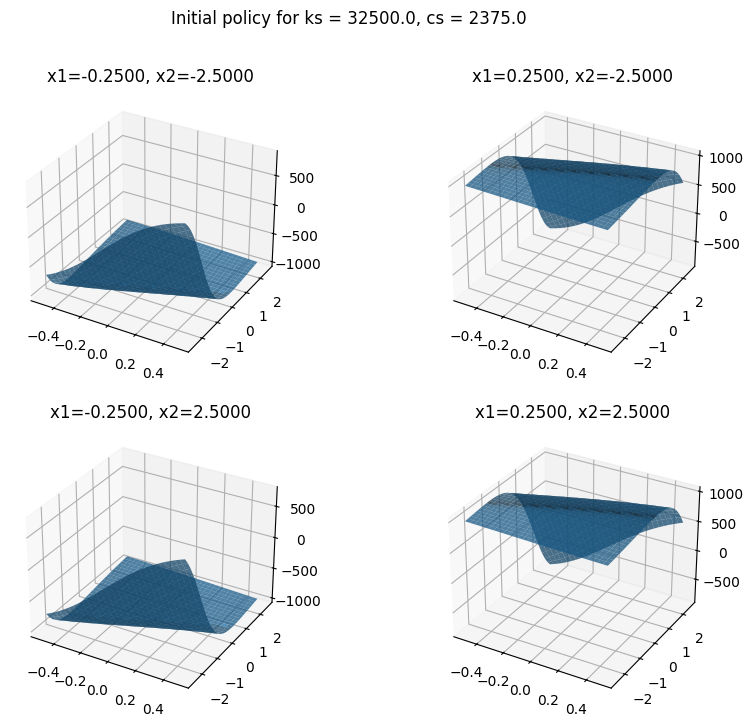

In [21]:
# Creating dataset
X1 = np.linspace(lb_x[0], ub_x[0], 2)
X2 = np.linspace(lb_x[1], ub_x[1], 2)
X3 = np.outer(np.linspace(lb_x[2], ub_x[2], 30), np.ones(30))
X4 = np.outer(np.linspace(lb_x[3], ub_x[3], 30), np.ones(30))
X4 = X4.T
ks_sample = np.linspace(lb_x[4], ub_x[4], 5)
cs_sample = np.linspace(lb_x[5], ub_x[5], 5)

Z = np.zeros((5,5,2,2,30,30))
for i1 in range(5):
    for i2 in range(5):
        for i in range(2):
            for j in range(2):
                for k in range(30):
                    for l in range(30):
                        inputs_tmp = np.array([X1[i],X2[j],X3[k,l],X4[k,l],ks_sample[i1],cs_sample[i2]])
                        inputs_tmp = (inputs_tmp - np.min(input_data, axis=0, keepdims=True)) / (np.max(input_data, axis=0, keepdims=True) - np.min(input_data, axis=0, keepdims=True))
                        normalized_inputs_tmp = torch.tensor(inputs_tmp.reshape(1,6), dtype=torch.float32).to(device)
                        Z_tmp = model_initial(normalized_inputs_tmp)*1000
                        Z[i1,i2,i,j,k,l] = Z_tmp.item()

# Creating figure
# fig = plt.figure(figsize =(14, 9))
# ax = plt.axes(projection ='3d')
 
# Creating plot
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(221, projection='3d')
ax1.plot_surface(X3, X4, Z[1,1,0,0,:,:], alpha=0.75)
ax1.title.set_text('x1='+'{0:.4f}'.format(X1[0])+', x2='+'{0:.4f}'.format(X2[0]))
ax2 = fig.add_subplot(222, projection='3d')
ax2.plot_surface(X3, X4, Z[1,1,1,0,:,:], alpha=0.75)
ax2.title.set_text('x1='+'{0:.4f}'.format(X1[1])+', x2='+'{0:.4f}'.format(X2[0]))
ax3 = fig.add_subplot(223, projection='3d')
ax3.plot_surface(X3, X4, Z[1,1,0,1,:,:], alpha=0.75)
ax3.title.set_text('x1='+'{0:.4f}'.format(X1[0])+', x2='+'{0:.4f}'.format(X2[1]))
ax4 = fig.add_subplot(224, projection='3d')
ax4.plot_surface(X3, X4, Z[1,1,1,1,:,:], alpha=0.75)
ax4.title.set_text('x1='+'{0:.4f}'.format(X1[1])+', x2='+'{0:.4f}'.format(X2[1]))
plt.suptitle('Initial policy for ks = '+str(ks_sample[1])+', cs = '+str(cs_sample[1]))
# Show plot
plt.show()

# Creating plot
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(221, projection='3d')
ax1.plot_surface(X3, X4, Z[3,3,0,0,:,:], alpha=0.75)
ax1.title.set_text('x1='+'{0:.4f}'.format(X1[0])+', x2='+'{0:.4f}'.format(X2[0]))
ax2 = fig.add_subplot(222, projection='3d')
ax2.plot_surface(X3, X4, Z[3,3,1,0,:,:], alpha=0.75)
ax2.title.set_text('x1='+'{0:.4f}'.format(X1[1])+', x2='+'{0:.4f}'.format(X2[0]))
ax3 = fig.add_subplot(223, projection='3d')
ax3.plot_surface(X3, X4, Z[3,3,0,1,:,:], alpha=0.75)
ax3.title.set_text('x1='+'{0:.4f}'.format(X1[0])+', x2='+'{0:.4f}'.format(X2[1]))
ax4 = fig.add_subplot(224, projection='3d')
ax4.plot_surface(X3, X4, Z[3,3,1,1,:,:], alpha=0.75)
ax4.title.set_text('x1='+'{0:.4f}'.format(X1[1])+', x2='+'{0:.4f}'.format(X2[1]))
plt.suptitle('Initial policy for ks = '+str(ks_sample[3])+', cs = '+str(cs_sample[3]))
# Show plot
plt.show()


In [128]:
ks = 20000.0
ks_normalized = (ks-env.ks_min)/(env.ks_max-env.ks_min)
cs = 3000.0
cs_normalized = (cs-env.cs_min)/(env.cs_max-env.cs_min)

s = env.reset(ks_normalized,cs_normalized)
print("Initial state:[{:.4f},{:.4f},{:.4f},{:.4f}]".format(s[0],s[1],s[2],s[3]))
score = 0
x_sys = np.zeros((4,101))
x_sys[:,0] = s
a_sys = np.zeros((100,))

for i in range(100):
    # mu = model(torch.from_numpy(s).float())
    inputs_tmp = np.array([s[0],s[1],s[2],s[3],ks,cs])
    normalized_inputs_tmp = (inputs_tmp - np.min(input_data, axis=0, keepdims=True)) / (np.max(input_data, axis=0, keepdims=True) - np.min(input_data, axis=0, keepdims=True))
    normalized_inputs_tmp = torch.tensor(normalized_inputs_tmp.reshape(1,6), dtype=torch.float32).to(device)
    mu = model_initial(normalized_inputs_tmp)*1000
    dist = Normal(mu, torch.tensor(10).to(device)) # std = 10
    a = dist.sample()
    a = min(max(a.item(), env.action_space.low[0]), env.action_space.high[0])
    # a = min(max(a.item(), -500), 500)
    a_sys[i] = a
    s_prime, r, done, _ = env.step(a,ks_normalized,cs_normalized)
    x_sys[:,i+1] = s_prime
    score += r
    print("Current state:[{:.4f},{:.4f},{:.4f},{:.4f}], Action: {:.4f}, Reward: {:.4f}, Next state:[{:.4f},{:.4f},{:.4f},{:.4f}]".format(s[0],s[1],s[2],s[3],a,r,s_prime[0],s_prime[1],s_prime[2],s_prime[3]))
    s = s_prime
print("Final score:{:.4f}".format(score))



Initial state:[-0.1000,-1.0000,-0.1000,-0.5000]
Current state:[-0.1000,-1.0000,-0.1000,-0.5000], Action: -476.2116, Reward: -6.8769, Next state:[0.0126,1.1144,-0.2008,0.8235]
Current state:[0.0126,1.1144,-0.2008,0.8235], Action: -497.4118, Reward: -4.2050, Next state:[-0.0024,-0.4694,-0.1412,0.7402]
Current state:[-0.0024,-0.4694,-0.1412,0.7402], Action: -611.1935, Reward: -3.7600, Next state:[0.0007,0.2823,-0.1100,0.7350]
Current state:[0.0007,0.2823,-0.1100,0.7350], Action: -553.3612, Reward: -2.9583, Next state:[0.0028,0.0872,-0.0813,0.6803]
Current state:[0.0028,0.0872,-0.0813,0.6803], Action: -520.0129, Reward: -3.2309, Next state:[-0.0038,0.6337,-0.0665,0.6837]
Current state:[-0.0038,0.6337,-0.0665,0.6837], Action: -572.8056, Reward: -2.3637, Next state:[0.0083,-0.0193,-0.0488,0.6189]
Current state:[0.0083,-0.0193,-0.0488,0.6189], Action: -459.3969, Reward: -1.4874, Next state:[-0.0004,0.3485,-0.0285,0.4721]
Current state:[-0.0004,0.3485,-0.0285,0.4721], Action: -393.4968, Reward

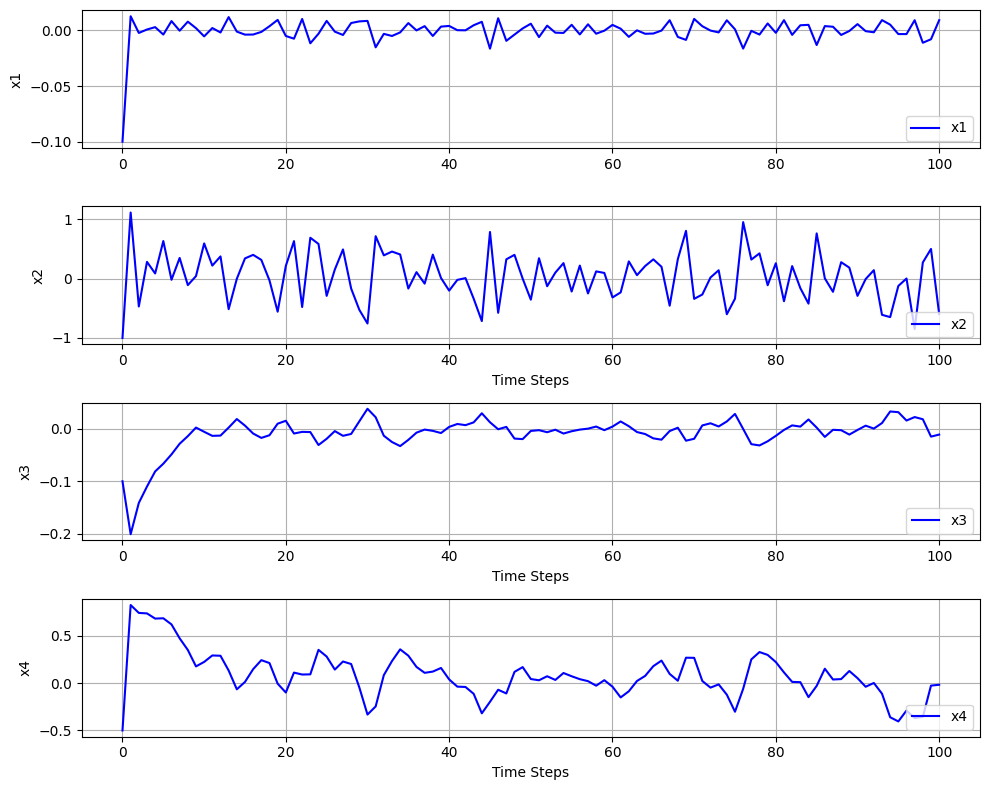

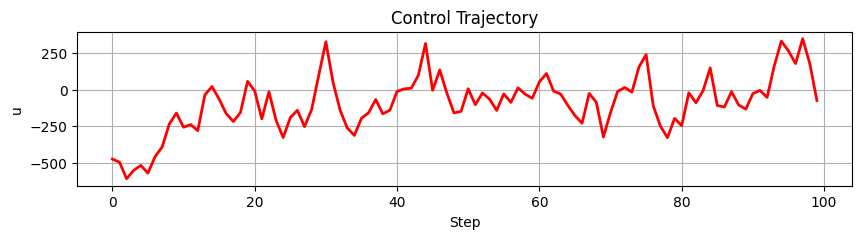

In [129]:
t_vec = np.arange(0, 101)

# Create the mean trajectories with 95% confidence interval
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8))
ax1.plot(t_vec, x_sys[0,:], color='b', label='x1')
# ax1.set_xlabel('Time Steps')
ax1.set_ylabel('x1')
# ax1.set_ylim((-3.75,1.0))
ax1.legend(loc='lower right')
ax1.grid(True)

ax2.plot(t_vec, x_sys[1,:], color='b', label='x2')
ax2.set_xlabel('Time Steps')
ax2.set_ylabel('x2')
# ax2.set_ylim((-4,2))
ax2.legend(loc='lower right')
ax2.grid(True)


ax3.plot(t_vec, x_sys[2,:], color='b', label='x3')
ax3.set_xlabel('Time Steps')
ax3.set_ylabel('x3')
# ax3.set_ylim((-4,2))
ax3.legend(loc='lower right')
ax3.grid(True)

ax4.plot(t_vec, x_sys[3,:], color='b', label='x4')
ax4.set_xlabel('Time Steps')
ax4.set_ylabel('x4')
# ax4.set_ylim((-4,2))
ax4.legend(loc='lower right')
ax4.grid(True)

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 2))
plt.plot(t_vec[:-1], a_sys, label='u', color='r', linestyle='-', linewidth=2)

plt.title('Control Trajectory')
plt.xlabel('Step')
plt.ylabel('u')

plt.grid(True)
plt.show()

# Train the initial value function

In [130]:
df = pd.read_csv('Data_value_susp_CCD2.csv')

class NeuralNetworkValue(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(6, 16),
            nn.Tanh(),
            nn.Linear(16, 32),
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 16),
            nn.Tanh(),
            nn.Linear(16, 1),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model_initial_value = NeuralNetworkValue().to(device)
data_value = np.array(df)
output_data_value = data_value/1000

# Convert data to PyTorch tensors
targets_value = torch.tensor(output_data_value, dtype=torch.float32).reshape(-1, 1)
targets_value = targets_value.to(device)

optimizer_value = torch.optim.SGD(model_initial_value.parameters(), lr=0.01)  # Stochastic Gradient Descent optimizer

num_epochs = 1000
batch_size = 64

for epoch in range(num_epochs):
    for i in range(0, len(input_data), batch_size):
        inputs_batch_value = inputs[i:i+batch_size]
        # Forward pass
        outputs_value = model_initial_value(inputs_batch_value)
        outputs_value = outputs_value.to(device)
        targets_batch_value = targets_value[i:i+batch_size]
        loss_value = criterion(outputs_value, targets_batch_value)

        # Backward pass and optimization
        optimizer_value.zero_grad()
        loss_value.backward()
        optimizer_value.step()
        
    # Print progress
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss_value.item():.4f}')



Epoch [100/1000], Loss: 0.1190
Epoch [200/1000], Loss: 0.0858
Epoch [300/1000], Loss: 0.0053
Epoch [400/1000], Loss: 0.0037
Epoch [500/1000], Loss: 0.0033
Epoch [600/1000], Loss: 0.0032
Epoch [700/1000], Loss: 0.0032
Epoch [800/1000], Loss: 0.0031
Epoch [900/1000], Loss: 0.0030
Epoch [1000/1000], Loss: 0.0027


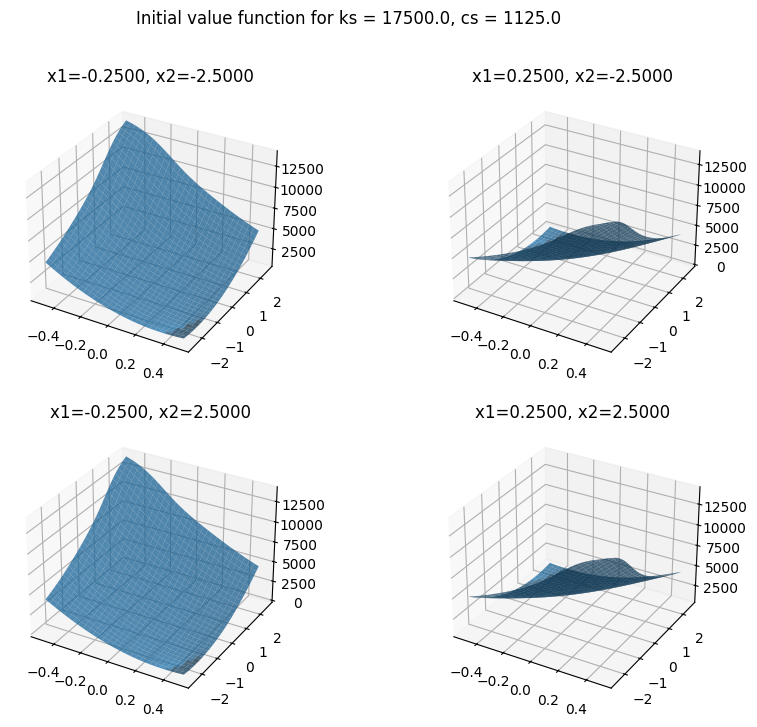

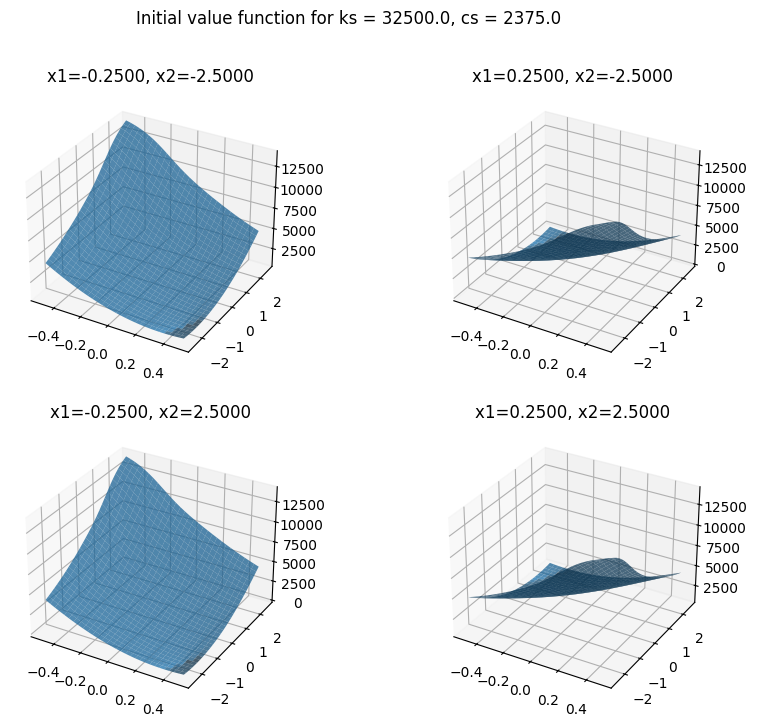

In [13]:
# Creating dataset
X1 = np.linspace(lb_x[0], ub_x[0], 2)
X2 = np.linspace(lb_x[1], ub_x[1], 2)
X3 = np.outer(np.linspace(lb_x[2], ub_x[2], 30), np.ones(30))
X4 = np.outer(np.linspace(lb_x[3], ub_x[3], 30), np.ones(30))
X4 = X4.T
ks_sample = np.linspace(lb_x[4], ub_x[4], 5)
cs_sample = np.linspace(lb_x[5], ub_x[5], 5)

Z = np.zeros((5,5,2,2,30,30))
for i1 in range(5):
    for i2 in range(5):
        for i in range(2):
            for j in range(2):
                for k in range(30):
                    for l in range(30):
                        inputs_tmp = np.array([X1[i],X2[j],X3[k,l],X4[k,l],ks_sample[i1],cs_sample[i2]])
                        inputs_tmp = (inputs_tmp - np.min(input_data, axis=0, keepdims=True)) / (np.max(input_data, axis=0, keepdims=True) - np.min(input_data, axis=0, keepdims=True))
                        normalized_inputs_tmp = torch.tensor(inputs_tmp.reshape(1,6), dtype=torch.float32).to(device)
                        Z_tmp = model_initial_value(normalized_inputs_tmp)*1000
                        Z[i1,i2,i,j,k,l] = Z_tmp.item()

# Creating figure
# fig = plt.figure(figsize =(14, 9))
# ax = plt.axes(projection ='3d')
 
# Creating plot
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(221, projection='3d')
ax1.plot_surface(X3, X4, Z[1,1,0,0,:,:], alpha=0.75)
ax1.title.set_text('x1='+'{0:.4f}'.format(X1[0])+', x2='+'{0:.4f}'.format(X2[0]))
ax2 = fig.add_subplot(222, projection='3d')
ax2.plot_surface(X3, X4, Z[1,1,1,0,:,:], alpha=0.75)
ax2.title.set_text('x1='+'{0:.4f}'.format(X1[1])+', x2='+'{0:.4f}'.format(X2[0]))
ax3 = fig.add_subplot(223, projection='3d')
ax3.plot_surface(X3, X4, Z[1,1,0,1,:,:], alpha=0.75)
ax3.title.set_text('x1='+'{0:.4f}'.format(X1[0])+', x2='+'{0:.4f}'.format(X2[1]))
ax4 = fig.add_subplot(224, projection='3d')
ax4.plot_surface(X3, X4, Z[1,1,1,1,:,:], alpha=0.75)
ax4.title.set_text('x1='+'{0:.4f}'.format(X1[1])+', x2='+'{0:.4f}'.format(X2[1]))
plt.suptitle('Initial value function for ks = '+str(ks_sample[1])+', cs = '+str(cs_sample[1]))
# Show plot
plt.show()

# Creating plot
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(221, projection='3d')
ax1.plot_surface(X3, X4, Z[3,3,0,0,:,:], alpha=0.75)
ax1.title.set_text('x1='+'{0:.4f}'.format(X1[0])+', x2='+'{0:.4f}'.format(X2[0]))
ax2 = fig.add_subplot(222, projection='3d')
ax2.plot_surface(X3, X4, Z[3,3,1,0,:,:], alpha=0.75)
ax2.title.set_text('x1='+'{0:.4f}'.format(X1[1])+', x2='+'{0:.4f}'.format(X2[0]))
ax3 = fig.add_subplot(223, projection='3d')
ax3.plot_surface(X3, X4, Z[3,3,0,1,:,:], alpha=0.75)
ax3.title.set_text('x1='+'{0:.4f}'.format(X1[0])+', x2='+'{0:.4f}'.format(X2[1]))
ax4 = fig.add_subplot(224, projection='3d')
ax4.plot_surface(X3, X4, Z[3,3,1,1,:,:], alpha=0.75)
ax4.title.set_text('x1='+'{0:.4f}'.format(X1[1])+', x2='+'{0:.4f}'.format(X2[1]))
plt.suptitle('Initial value function for ks = '+str(ks_sample[3])+', cs = '+str(cs_sample[3]))
# Show plot
plt.show()

Test if we can initialize the neural network model with the specified weights and bias

In [131]:
# Take out the weights and biases from a pretrained policy
model_parameter = list(model_initial.linear_relu_stack.parameters())
print(model_parameter[0].size()) # First layer weights
print(model_parameter[1].size()) # First layer biases
print(model_parameter[2].size()) # Second layer weights
print(model_parameter[3].size()) # Second layer biases
print(model_parameter[4].size()) # Third layer weights
print(model_parameter[5].size()) # Third layer biases
print(model_parameter[6].size()) # Forth layer weights
print(model_parameter[7].size()) # Forth layer biases
print(model_parameter[8].size()) # Output layer weights
print(model_parameter[9].size()) # Output layer biases

model_value_parameter = list(model_initial_value.linear_relu_stack.parameters())
print(model_value_parameter[0].size()) # First layer weights
print(model_value_parameter[1].size()) # First layer biases
print(model_value_parameter[2].size()) # Second layer weights
print(model_value_parameter[3].size()) # Second layer biases
print(model_value_parameter[4].size()) # Third layer weights
print(model_value_parameter[5].size()) # Third layer biases
print(model_value_parameter[6].size()) # Forth layer weights
print(model_value_parameter[7].size()) # Forth layer biases
print(model_value_parameter[8].size()) # Output layer weights
print(model_value_parameter[9].size()) # Output layer biases

xmin = np.min(input_data, axis=0, keepdims=True)
xmin = torch.tensor(xmin)
print(xmin[0,0:4])
xmax = np.max(input_data, axis=0, keepdims=True)
xmax = torch.tensor(xmax)


torch.Size([16, 6])
torch.Size([16])
torch.Size([32, 16])
torch.Size([32])
torch.Size([32, 32])
torch.Size([32])
torch.Size([16, 32])
torch.Size([16])
torch.Size([1, 16])
torch.Size([1])
torch.Size([16, 6])
torch.Size([16])
torch.Size([32, 16])
torch.Size([32])
torch.Size([32, 32])
torch.Size([32])
torch.Size([16, 32])
torch.Size([16])
torch.Size([1, 16])
torch.Size([1])
tensor([-0.2500, -2.4994, -0.4999, -2.4991], dtype=torch.float64)


## Hyparameters for RL-PPO

Suggestions from ChatGPT:
1. gamma: Discount Factor
2. lmbda: Generalized Advantage Estimation (GAE) Lambda. A lower lmbda reduces bias but increases variance, while a higher lmbda increases bias but smoothens advantage estimation. Try values in [0.8, 0.95].
3. eps_clip: Clipping Parameter. The eps_clip = 0.2 is typical for PPO, but you might experiment with slightly smaller values like 0.1 if the policy updates are too aggressive. A higher value make the policy update more aggresive
4. rollout_len: rollout length
5. buffer_size: buffer size (With rollout_len = 10 and buffer_size = 10, you’re processing relatively small batches. Increasing these values may improve gradient estimation at the expense of computational resources.)
6. minibatch_size: batch size. minibatch_size = 32 is a reasonable choice, but try increasing this (e.g., 64 or 128) to stabilize gradient updates.

Note: increasing buffer_size and minibatch_size increases the period of update and training but makes the gradient more stable.

In [ ]:
#Hyperparameters
learning_rate       = 0.00001
learning_rate_plant = 0.00001
gamma               = 1
lmbda               = 0.9
eps_clip            = 0.2
K_epoch             = 20
rollout_len         = 20
buffer_size         = 10
minibatch_size      = 32

class PPO_num(nn.Module):
    def __init__(self):
        super(PPO_num, self).__init__()
        self.data = []

        self.fc1 = nn.Linear(6, 16)
        self.fc2 = nn.Linear(16, 32)
        self.fc3 = nn.Linear(32, 32)
        self.fc4 = nn.Linear(32, 16)
        self.fc_mu = nn.Linear(16, 1)

        self.fc5 = nn.Linear(6, 16)
        self.fc6 = nn.Linear(16, 32)
        self.fc7 = nn.Linear(32, 32)
        self.fc8 = nn.Linear(32, 16)
        self.fc_std  = nn.Linear(16, 1)

        self.fc9   = nn.Linear(6, 16)
        self.fc10  = nn.Linear(16, 32)
        self.fc11  = nn.Linear(32, 32)
        self.fc12  = nn.Linear(32, 16)
        self.fc_v  = nn.Linear(16, 1)

        with torch.no_grad():
            # Weights and bias for policy function (mean)
            self.fc1.weight.copy_(model_parameter[0])
            self.fc1.bias.copy_(model_parameter[1])
            self.fc2.weight.copy_(model_parameter[2])
            self.fc2.bias.copy_(model_parameter[3])
            self.fc3.weight.copy_(model_parameter[4])
            self.fc3.bias.copy_(model_parameter[5])
            self.fc4.weight.copy_(model_parameter[6])
            self.fc4.bias.copy_(model_parameter[7])
            self.fc_mu.weight.copy_(model_parameter[8])
            self.fc_mu.bias.copy_(model_parameter[9])

            # Weights and bias for policy function (std)
            self.fc5.weight.copy_(torch.zeros(16, 6))
            self.fc5.bias.copy_(torch.ones(16,)*0.01)
            self.fc6.weight.copy_(torch.zeros(32, 16))
            self.fc6.bias.copy_(torch.ones(32,)*0.01)
            self.fc7.weight.copy_(torch.zeros(32, 32))
            self.fc7.bias.copy_(torch.ones(32,)*0.01)
            self.fc8.weight.copy_(torch.zeros(16,32))
            self.fc8.bias.copy_(torch.ones(16,)*0.01)
            self.fc_std.weight.copy_(torch.zeros(16,))
            self.fc_std.bias.copy_(torch.ones(1,)*0.1)

            # Weights and bias for value function
            self.fc9.weight.copy_(model_value_parameter[0])
            self.fc9.bias.copy_(model_value_parameter[1])
            self.fc10.weight.copy_(model_value_parameter[2])
            self.fc10.bias.copy_(model_value_parameter[3])
            self.fc11.weight.copy_(model_value_parameter[4])
            self.fc11.bias.copy_(model_value_parameter[5])
            self.fc12.weight.copy_(model_value_parameter[6])
            self.fc12.bias.copy_(model_value_parameter[7])
            self.fc_v.weight.copy_(model_value_parameter[8])
            self.fc_v.bias.copy_(model_value_parameter[9])

        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate, weight_decay=1e-4)
        self.optimization_step = 0

    def pi(self, x, max_value = 0.5):
        Tanh_fuc = nn.Tanh()
        Softplus_fuc= nn.Softplus(beta=100) # To avoid negative value for std
        f1 = self.fc1(x)
        f2 = self.fc2(Tanh_fuc(f1))
        f3 = self.fc3(f2)
        f4 = self.fc4(Tanh_fuc(f3))
        mu = self.fc_mu(f4)
        
        f5 = self.fc5(x)
        f6 = self.fc6(Tanh_fuc(f5))
        f7 = self.fc7(f6)
        f8 = self.fc8(Tanh_fuc(f7))
        # std = F.softplus(self.fc_std(f6))
        std = torch.min(Softplus_fuc(self.fc_std(f8)), torch.tensor(max_value))
        return mu, std
    
    def v(self, x):
        # x = F.relu(self.fc1(x))
        # v = self.fc_v(x)
        Tanh_fuc = nn.Tanh()
        f9 = self.fc9(x)
        f10 = self.fc10(Tanh_fuc(f9))
        f11 = self.fc11(f10)
        f12 = self.fc12(Tanh_fuc(f11))
        v = self.fc_v(f12)
        return v
      
    def put_data(self, transition):
        self.data.append(transition)
        
    def make_batch(self):
        s_batch, a_batch, r_batch, s_prime_batch, prob_a_batch, done_batch = [], [], [], [], [], []
        data = []

        for j in range(buffer_size):
            for i in range(minibatch_size):
                rollout = self.data.pop()
                s_lst, a_lst, r_lst, s_prime_lst, prob_a_lst, done_lst = [], [], [], [], [], []

                for transition in rollout:
                    s, a, r, s_prime, prob_a, done = transition
                    
                    s_lst.append(s)
                    a_lst.append([a])
                    r_lst.append([r])
                    s_prime_lst.append(s_prime)
                    prob_a_lst.append([prob_a])
                    done_mask = 0 if done else 1
                    done_lst.append([done_mask])

                s_batch.append(s_lst)
                a_batch.append(a_lst)
                r_batch.append(r_lst)
                s_prime_batch.append(s_prime_lst)
                prob_a_batch.append(prob_a_lst)
                done_batch.append(done_lst)
                    
            mini_batch = torch.tensor(s_batch, dtype=torch.float), torch.tensor(a_batch, dtype=torch.float), \
                          torch.tensor(r_batch, dtype=torch.float), torch.tensor(s_prime_batch, dtype=torch.float), \
                          torch.tensor(done_batch, dtype=torch.float), torch.tensor(prob_a_batch, dtype=torch.float)
            data.append(mini_batch)

        return data

    def calc_advantage(self, data, ks = 27692.0, cs = 1906.5):
        data_with_adv = []
        for mini_batch in data:
            s, a, r, s_prime, done_mask, old_log_prob = mini_batch
            with torch.no_grad():
                tensor_size = torch.Tensor.size(s_prime)
                new_tensor1 = torch.full((tensor_size[0],tensor_size[1],1), ks)
                new_tensor2 = torch.full((tensor_size[0],tensor_size[1],1), cs)
                # Concatenate the original tensor and the new tensor along the last dimension
                x = torch.cat((s, new_tensor1, new_tensor2), dim=2)
                x_normalized = (x-xmin)/(xmax-xmin)
                x_normalized = x_normalized.type(torch.float32)
                x_prime = torch.cat((s_prime, new_tensor1, new_tensor2), dim=2)
                x_prime_normalized = (x_prime-xmin)/(xmax-xmin)
                x_prime_normalized = x_prime_normalized.type(torch.float32)
                td_target = r + gamma * self.v(x_prime_normalized)
                delta = td_target - self.v(x_normalized)
            delta = delta.numpy()

            advantage_lst = []
            advantage = 0.0
            for delta_t in delta[::-1]:
                advantage = gamma * lmbda * advantage + delta_t[0]
                advantage_lst.append([advantage])
            advantage_lst.reverse()
            advantage = torch.tensor(advantage_lst, dtype=torch.float)
            data_with_adv.append((s, a, r, s_prime, done_mask, old_log_prob, td_target, advantage))

        return data_with_adv


    def train_net(self,ks,cs):
        global ks_torch, cs_torch
        ks_torch = torch.tensor(ks, requires_grad=True, dtype=torch.float32)
        cs_torch = torch.tensor(cs, requires_grad=True, dtype=torch.float32)
        if len(self.data) == minibatch_size * buffer_size:
            data = self.make_batch()
            data = self.calc_advantage(data,ks,cs)

            for i in range(K_epoch):
                for mini_batch in data:
                    s, a, r, s_prime, done_mask, old_log_prob, td_target, advantage = mini_batch
                    # compute the loss and gradient
                    tensor_size = torch.Tensor.size(s)
                    # new_tensor = torch.full((tensor_size[0],tensor_size[1],1), p_torch_in)
                    new_tensor1 = ks_torch.expand(tensor_size[0], tensor_size[1], 1)
                    new_tensor2 = cs_torch.expand(tensor_size[0], tensor_size[1], 1)
                    # Concatenate the original tensor and the new tensor along the last dimension
                    x = torch.cat((s, new_tensor1, new_tensor2), dim=2)
                    x_normalized = (x-xmin)/(xmax-xmin)
                    x_normalized = x_normalized.type(torch.float32)
                    mu, std = self.pi(x_normalized, max_value=0.5)
                    dist = Normal(mu, std)
                    log_prob = dist.log_prob(a)
                    ratio = torch.exp(log_prob - old_log_prob)  # a/b == exp(log(a)-log(b))

                    surr1 = ratio * advantage
                    surr2 = torch.clamp(ratio, 1-eps_clip, 1+eps_clip) * advantage
                    # clamp function ensures ratio is within the range
                    loss = -torch.min(surr1, surr2) + F.smooth_l1_loss(self.v(x_normalized) , td_target)
                    # compute the Smooth L1 loss, which is less sensitive to outliers than the MSE loss

                    self.optimizer.zero_grad()
                    loss.mean().backward() # compute the gradients of the loss with respect to the model parameters
                    nn.utils.clip_grad_norm_(self.parameters(), 1.0) # clip the gradients' norm to prevent the exploding gradient problem, clipped to a maximum of 1.0 in this case
                    self.optimizer.step() # update the model parameters using the gradients computed during backpropagation
                    self.optimization_step += 1

    def train_net_CCD(self,ks,cs): # co-optimizing policy and the system parameter p
        global p_torch
        ks_torch = torch.tensor(ks, dtype=torch.float32)
        cs_torch = torch.tensor(cs, dtype=torch.float32)
        tensor_list = [(ks_torch-xmin[0,4])/(xmax[0,4]-xmin[0,4]),(cs_torch-xmin[0,5])/(xmax[0,5]-xmin[0,5])]
        p_torch = torch.tensor([t.item() for t in tensor_list], dtype=torch.float64, requires_grad=True) # Convert the list of tensors into a single tensor
        if len(self.data) == minibatch_size * buffer_size:
            data = self.make_batch()
            data = self.calc_advantage(data,ks,cs)
            # optimizer_p = torch.optim.SGD([p_torch], lr=0.001) # define the optimizer that only updates p
            optimizer_p = torch.optim.Adam([p_torch], lr=learning_rate_plant, weight_decay=1e-4) # define the optimizer that only updates p; 'weight_decay' can help with overfitting

            for i in range(K_epoch):
                for mini_batch in data:
                    s, a, r, s_prime, done_mask, old_log_prob, td_target, advantage = mini_batch
                    # compute the loss and gradient
                    tensor_size = torch.Tensor.size(s)
                    new_tensor1 = p_torch[0].expand(tensor_size[0], tensor_size[1], 1)
                    new_tensor2 = p_torch[1].expand(tensor_size[0], tensor_size[1], 1)
                    # Concatenate the original tensor and the new tensor along the last dimension
                    x_normalized = torch.cat((s, new_tensor1, new_tensor2), dim=2)
                    # x = torch.cat((s, new_tensor1, new_tensor2), dim=2)
                    # x_normalized = (x-xmin)/(xmax-xmin)
                    x_normalized = x_normalized.type(torch.float32)
                    mu, std = self.pi(x_normalized, max_value=0.5)
                    dist = Normal(mu, std)
                    log_prob = dist.log_prob(a)
                    ratio = torch.exp(log_prob - old_log_prob)  # a/b == exp(log(a)-log(b))

                    surr1 = ratio * advantage
                    surr2 = torch.clamp(ratio, 1-eps_clip, 1+eps_clip) * advantage
                    # clamp function ensures ratio is within the range
                    loss = -torch.min(surr1, surr2) + F.smooth_l1_loss(self.v(x_normalized) , td_target)
                    # compute the Smooth L1 loss, which is less sensitive to outliers than the MSE loss

                    # autograd
                    optimizer_p.zero_grad()
                    loss.mean().backward(retain_graph=True) # Perform backward pass to compute gradients
                    optimizer_p.step()
                    # print(p_torch)

                    self.optimizer.zero_grad()
                    loss.mean().backward() # compute the gradients of the loss with respect to the model parameters
                    nn.utils.clip_grad_norm_(self.parameters(), 1.0) # clip the gradients' norm to prevent the exploding gradient problem, clipped to a maximum of 1.0 in this case
                    self.optimizer.step() # update the model parameters using the gradients computed during backpropagation
                    self.optimization_step += 1
        return p_torch[0], p_torch[1]


In [133]:
env = DynamicSystemEnv()
RLmodel_initial = PPO_num()

In [134]:
from scipy.stats import sem, t
ks = 27692.0
ks_normalized = (ks-env.ks_min)/(env.ks_max-env.ks_min)
cs = 1906.5
cs_normalized = (cs-env.cs_min)/(env.cs_max-env.cs_min)
score_total_initial = []
num_replicates = 1000
x_sys_initial = np.zeros((num_replicates,101,4))
a_sys_initial = np.zeros((num_replicates,100,))
for k in range(num_replicates):
    s = env.reset(ks,cs)
    score = 0
    
    x_sys_initial[k,0,:] = np.array([s[0],s[1],s[2],s[3]])
    for i in range(100):
        x_tmp = np.append(s,ks)
        x_tmp = np.append(x_tmp,cs)
        x = torch.from_numpy(x_tmp).float()
        x = (x - np.min(input_data, axis=0, keepdims=True)) / (np.max(input_data, axis=0, keepdims=True) - np.min(input_data, axis=0, keepdims=True))
        normalized_inputs_tmp = torch.tensor(x.reshape(1,6), dtype=torch.float32)
        mu, std = RLmodel_initial.pi(normalized_inputs_tmp)
        dist = Normal(mu, std)
        a_tensor = dist.sample()
        a = min(max(a_tensor.item()*1000, env.action_space.low[0]), env.action_space.high[0])
        # a = min(max(mu.item(), env.action_space.low[0]), env.action_space.high[0])
        s_prime, r, done, _ = env.step(a,ks_normalized,cs_normalized)
        x_sys_initial[k,i+1,:] = s_prime
        a_sys_initial[k,i] = a
        score += r
        # print("Current state:[{:.4f},{:.4f},{:.4f},{:.4f}], Action: {:.4f}, Reward: {:.4f}, Next state:[{:.4f},{:.4f},{:.4f},{:.4f}]".format(s[0],s[1],s[2],s[3],a,r,s_prime[0],s_prime[1],s_prime[2],s_prime[3]))
        s = s_prime
    score_total_initial.append(score)
    print("# of episode :{}, score : {:.4f}".format(k, score))


/tmp/ipykernel_27646/2819130001.py:19: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  x = (x - np.min(input_data, axis=0, keepdims=True)) / (np.max(input_data, axis=0, keepdims=True) - np.min(input_data, axis=0, keepdims=True))
/tmp/ipykernel_27646/2819130001.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  normalized_inputs_tmp = torch.tensor(x.reshape(1,6), dtype=torch.float32)


# of episode :0, score : -123.0404
# of episode :1, score : -116.4847
# of episode :2, score : -144.5419
# of episode :3, score : -137.4433
# of episode :4, score : -119.0201
# of episode :5, score : -125.0163
# of episode :6, score : -132.9052
# of episode :7, score : -127.2249
# of episode :8, score : -114.9926


KeyboardInterrupt: 

## Save the data (1000 replicates using the initial policy)

In [107]:
import pickle

data_to_save = {
    'model_initial': model_initial, # RL model
    'env': env,
    'x_sys_initial': x_sys_initial,
    'a_sys_initial': a_sys_initial,
    # Add more variables as needed
}

with open('RL_PPO_CCD_susp_initial.pkl', 'wb') as file:
    pickle.dump(data_to_save, file)


In [26]:
import pickle

with open('RL_PPO_CCD_susp_initial.pkl', 'rb') as file:
    loaded_variables = pickle.load(file)

model_initial = loaded_variables['model_initial']
x_sys_initial = loaded_variables['x_sys_initial']
a_sys_initial = loaded_variables['a_sys_initial']


Average Score: -87.249
Std of Score: 11.932


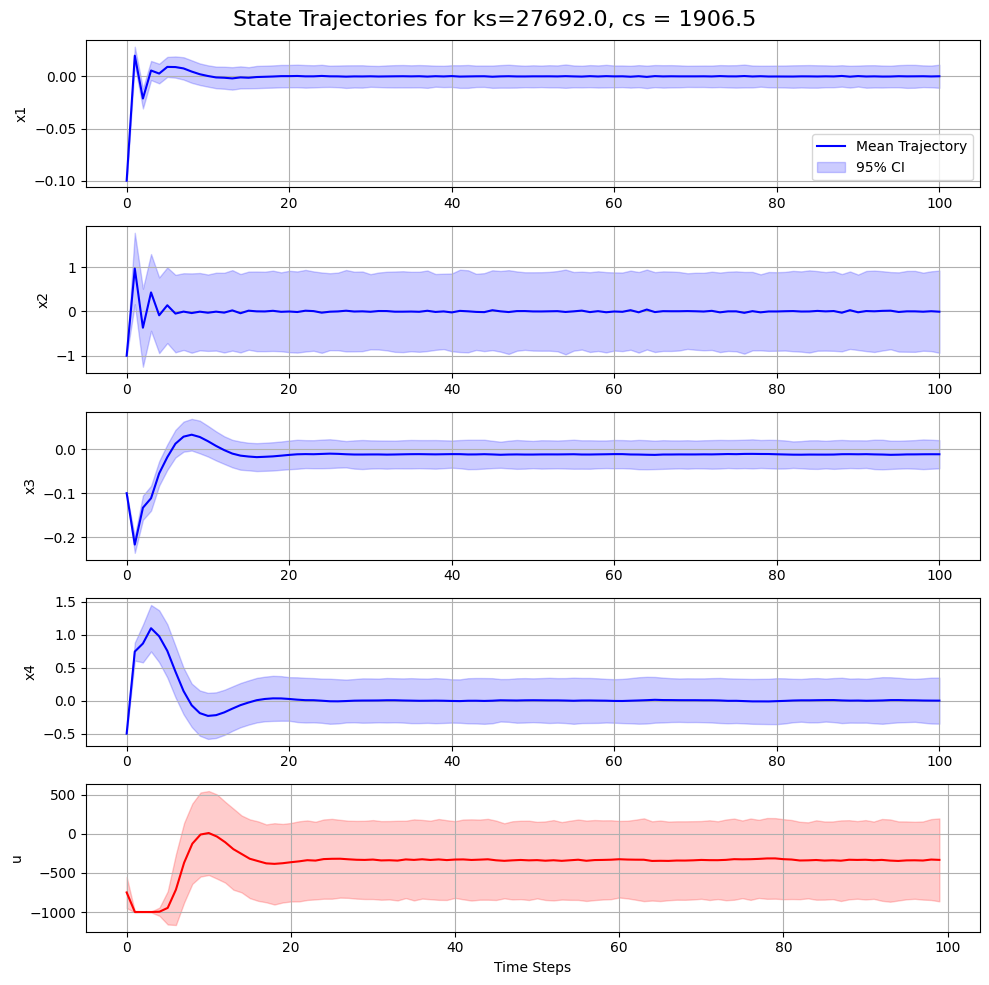

In [ ]:
from scipy.stats import sem, t

avg_score_initial = np.average(score_total_initial)
std_score_initial = np.std(score_total_initial)
print("Average Score: {:.3f}".format(avg_score_initial))
print("Std of Score: {:.3f}".format(std_score_initial))

mean_traj1_initial = np.mean(x_sys_initial[:,:,0], axis=0)
mean_traj2_initial = np.mean(x_sys_initial[:,:,1], axis=0)
mean_traj3_initial = np.mean(x_sys_initial[:,:,2], axis=0)
mean_traj4_initial = np.mean(x_sys_initial[:,:,3], axis=0)
mean_traj5_initial = np.mean(a_sys_initial, axis=0)

# Calculate the standard deviation
sem_traj1_initial = np.std(x_sys_initial[:,:,0], axis=0)
sem_traj2_initial = np.std(x_sys_initial[:,:,1], axis=0)
sem_traj3_initial = np.std(x_sys_initial[:,:,2], axis=0)
sem_traj4_initial = np.std(x_sys_initial[:,:,3], axis=0)
sem_traj5_initial = np.std(a_sys_initial, axis=0)

# Calculate the t critical value for 95% confidence interval
confidence = 0.95
n = x_sys_initial.shape[0]  # number of trajectories
t_critical = t.ppf((1 + confidence) / 2., n - 1)

# Calculate the margin of error
margin_of_error1 = t_critical * sem_traj1_initial
margin_of_error2 = t_critical * sem_traj2_initial
margin_of_error3 = t_critical * sem_traj3_initial
margin_of_error4 = t_critical * sem_traj4_initial
margin_of_error5 = t_critical * sem_traj5_initial

# Calculate the confidence interval
lower_bound1 = mean_traj1_initial - margin_of_error1
upper_bound1 = mean_traj1_initial + margin_of_error1
lower_bound2 = mean_traj2_initial - margin_of_error2
upper_bound2 = mean_traj2_initial + margin_of_error2
lower_bound3 = mean_traj3_initial - margin_of_error3
upper_bound3 = mean_traj3_initial + margin_of_error3
lower_bound4 = mean_traj4_initial - margin_of_error4
upper_bound4 = mean_traj4_initial + margin_of_error4
lower_bound5 = mean_traj5_initial - margin_of_error5
upper_bound5 = mean_traj5_initial + margin_of_error5

t_vec = np.arange(0, 101)

# Create the mean trajectories with 95% confidence interval
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(10, 10))

ax1.plot(t_vec, mean_traj1_initial, color='b', label='Mean Trajectory')
ax1.fill_between(t_vec, lower_bound1, upper_bound1, color='b', alpha=0.2, label="95% CI")
# ax1.set_xlabel('Time Steps')
ax1.set_ylabel('x1')
# ax1.set_ylim((-3.75,1.0))
ax1.legend(loc='lower right')
ax1.grid(True)

ax2.plot(t_vec, mean_traj2_initial, color='b', label='Mean Trajectory')
ax2.fill_between(t_vec, lower_bound2, upper_bound2, color='b', alpha=0.2, label="95% CI")
# ax2.set_xlabel('Time Steps')
ax2.set_ylabel('x2')
# ax2.set_ylim((-4,2))
ax2.grid(True)

ax3.plot(t_vec, mean_traj3_initial, color='b', label='Mean Trajectory')
ax3.fill_between(t_vec, lower_bound3, upper_bound3, color='b', alpha=0.2, label="95% CI")
# ax3.set_xlabel('Time Steps')
ax3.set_ylabel('x3')
# ax3.set_ylim((-4,2))
ax3.grid(True)

ax4.plot(t_vec, mean_traj4_initial, color='b', label='Mean Trajectory')
ax4.fill_between(t_vec, lower_bound4, upper_bound4, color='b', alpha=0.2, label="95% CI")
# ax4.set_xlabel('Time Steps')
ax4.set_ylabel('x4')
# ax4.set_ylim((-4,2))
ax4.grid(True)

ax5.plot(t_vec[:-1], mean_traj5_initial, color='r', label='Mean Trajectory')
ax5.fill_between(t_vec[:-1], lower_bound5, upper_bound5, color='r', alpha=0.2, label="95% CI")
ax5.set_xlabel('Time Steps')
ax5.set_ylabel('u')
ax5.grid(True)

plt.suptitle('State Trajectories for ks='+'{0:.1f}'.format(ks)+', cs = '+'{0:.1f}'.format(cs), fontsize=16)
plt.tight_layout()
plt.show()

## CCD

In [148]:
import copy

model = copy.deepcopy(RLmodel_initial)

xmin_array = xmin.numpy()
xmax_array = xmax.numpy()

ks = 27692.0
# ks = 13300
ks_normalized = (ks-env.ks_min)/(env.ks_max-env.ks_min)
cs = 1906.5
# cs = 2514.0
cs_normalized = (cs-env.cs_min)/(env.cs_max-env.cs_min)
print_interval = 10
rollout = []
score_total = 0.0
score_history = []
ks_history = []
cs_history = []
patience = 100
threshold = 0.01  # Minimum improvement considered significant
best_reward = -float('inf')  # Initialize best reward
no_improvement_count = 0  # Counter for no improvement
for n_epi in range(10000):
    s = env.reset(ks_normalized,cs_normalized)
    done = False
    count = 0
    score = 0.0
    while count < 100:
        for t in range(rollout_len):
            x_tmp = np.append(s,ks)
            x_tmp = np.append(x_tmp,cs)
            s_normalized = (s - xmin_array[0][0:4]) / (xmax_array[0][0:4] - xmin_array[0][0:4])
            x = (x_tmp - xmin_array[0]) / (xmax_array[0] - xmin_array[0])
            normalized_inputs_tmp = torch.tensor(x.reshape(1,6), dtype=torch.float32)
            mu, std = model.pi(normalized_inputs_tmp)
            dist = Normal(mu, std)
            a = dist.sample()
            log_prob = dist.log_prob(a)
            action = min(max(a.item()*1000, env.action_space.low[0]), env.action_space.high[0])
            s_prime, r, done, _ = env.step([action],ks_normalized,cs_normalized)
            s_prime_normalized = (s_prime - xmin_array[0][0:4]) / (xmax_array[0][0:4] - xmin_array[0][0:4])
            rollout.append((s_normalized, action/1000, r/1000.0, s_prime_normalized, log_prob.item(), done))
            if len(rollout) == rollout_len:
                model.put_data(rollout)
                rollout = []

            s = s_prime

            score += r
            count += 1

        ks_torch_new, cs_torch_new = model.train_net_CCD(ks,cs)
        ks_normalized_ccd = ks_torch_new.item()
        cs_normalized_ccd = cs_torch_new.item()
        
        # Note that the normalizations for CCD training and step(), reset() are different
        ks = ks_normalized_ccd*(xmax[0,4]-xmin[0,4]) + xmin[0,4]
        cs = cs_normalized_ccd*(xmax[0,5]-xmin[0,5]) + xmin[0,5]
        
        ks_normalized = (ks-env.ks_min)/(env.ks_max-env.ks_min)
        cs_normalized = (cs-env.cs_min)/(env.cs_max-env.cs_min)

    score_total = score_total+score
    score_history.append([n_epi,score])
    ks_history.append([n_epi,ks])
    cs_history.append([n_epi,cs])

    # print("# of episode :{}, score : {:.1f}, ks = {:.4f}, cs = {:.4f}".format(n_epi, score, ks, cs))

    if n_epi%print_interval==0 and n_epi!=0:
        if n_epi==10:
            avg_score = score_total/(print_interval+1)
            print("# of episode :{}, avg score : {:.1f}, ks = {:.4f}, cs = {:.4f}".format(n_epi, avg_score, ks, cs))
        else:
            avg_score = score_total/print_interval
            print("# of episode :{}, avg score : {:.1f}, ks = {:.4f}, cs = {:.4f}".format(n_epi, avg_score, ks, cs))
        score_total = 0.0

        # Check if we have improved
        if avg_score > best_reward + 0.01:
            best_reward = avg_score
            no_improvement_count = 0  # Reset the counter
        else:
            no_improvement_count += 1

        # Early stopping check
        # if no_improvement_count >= patience:
        #     print(f"Early stopping triggered at epoch {n_epi} with reward {avg_score}")
        #     break

env.close()
print("The final ks = {:.4f}".format(ks)+', cs = {:.4f}'.format(cs))

model_retrain = copy.deepcopy(model) # save the model (for back up)

/tmp/ipykernel_1743789/2525276600.py:216: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ks_torch = torch.tensor(ks, dtype=torch.float32)
/tmp/ipykernel_1743789/2525276600.py:217: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cs_torch = torch.tensor(cs, dtype=torch.float32)


# of episode :10, avg score : -73.2, ks = 27692.0000, cs = 1906.5000
# of episode :20, avg score : -81.8, ks = 27692.0000, cs = 1906.5000
# of episode :30, avg score : -77.6, ks = 27692.0000, cs = 1906.5000
# of episode :40, avg score : -72.5, ks = 27692.0000, cs = 1906.5000
# of episode :50, avg score : -77.1, ks = 27692.0000, cs = 1906.5000
# of episode :60, avg score : -74.9, ks = 27692.0000, cs = 1906.5000
# of episode :70, avg score : -74.4, ks = 27647.0781, cs = 1907.9677
# of episode :80, avg score : -71.8, ks = 27647.0781, cs = 1907.9677
# of episode :90, avg score : -72.3, ks = 27647.0781, cs = 1907.9677
# of episode :100, avg score : -77.6, ks = 27647.0781, cs = 1907.9677
# of episode :110, avg score : -76.1, ks = 27647.0781, cs = 1907.9677
# of episode :120, avg score : -70.6, ks = 27647.0781, cs = 1907.9677
# of episode :130, avg score : -77.3, ks = 27602.3340, cs = 1906.1904
# of episode :140, avg score : -76.5, ks = 27602.3340, cs = 1906.1904
# of episode :150, avg score 

In [149]:
import matplotlib.pyplot as plt

score_history_array = np.array(score_history).T
epoch = score_history_array[0,:]
score_history_array = score_history_array[1,:]
score_history_avg = score_history_array.reshape(-1, 10).mean(axis=1)

ks_history_array = np.array(ks_history).T
ks_history_array = ks_history_array[1,:]
cs_history_array = np.array(cs_history).T
cs_history_array = cs_history_array[1,:]

plt.figure(figsize=(8, 5))
plt.plot(epoch[::10], score_history_avg)
plt.xlabel('Epoch')
plt.ylabel('Average Return')
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(epoch[::10], ks_history_array[::10])
plt.xlabel('Epoch')
plt.ylabel('$k_s$ (Spring constant)')
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(epoch[::10], cs_history_array[::10])
plt.xlabel('Epoch')
plt.ylabel('$c_s$ (Damping constant)')
plt.show()

ValueError: cannot reshape array of size 1221 into shape (10)

In [113]:
s = env.reset(ks_normalized,cs_normalized)
print("Initial state:[{:.4f},{:.4f},{:.4f},{:.4f}]".format(s[0],s[1],s[2],s[3]))
score = 0
x_sys = np.zeros((4,101))
x_sys[:,0] = s
a_sys = np.zeros((100,))

for i in range(100):
    # mu = model(torch.from_numpy(s).float())
    inputs_tmp = np.array([s[0],s[1],s[2],s[3],ks,cs])
    normalized_inputs_tmp = (inputs_tmp - np.min(input_data, axis=0, keepdims=True)) / (np.max(input_data, axis=0, keepdims=True) - np.min(input_data, axis=0, keepdims=True))
    normalized_inputs_tmp = torch.tensor(normalized_inputs_tmp.reshape(1,6), dtype=torch.float32)
    mu, std = model.pi(normalized_inputs_tmp)
    dist = Normal(mu, std)
    a = dist.sample()
    a = min(max(a.item()*1000, env.action_space.low[0]), env.action_space.high[0])
    # a = min(max(a.item(), -500), 500)
    a_sys[i] = a
    s_prime, r, done, _ = env.step(a,ks_normalized,cs_normalized)
    x_sys[:,i+1] = s_prime
    score += r
    print("Current state:[{:.4f},{:.4f},{:.4f},{:.4f}], Action: {:.4f}, Reward: {:.4f}, Next state:[{:.4f},{:.4f},{:.4f},{:.4f}]".format(s[0],s[1],s[2],s[3],a,r,s_prime[0],s_prime[1],s_prime[2],s_prime[3]))
    s = s_prime
print("Final score:{:.4f}".format(score))



Initial state:[-0.1000,-1.0000,-0.1000,-0.5000]
Current state:[-0.1000,-1.0000,-0.1000,-0.5000], Action: -782.1648, Reward: -11.4469, Next state:[0.0045,1.8187,-0.2288,0.9910]
Current state:[0.0045,1.8187,-0.2288,0.9910], Action: -1000.0000, Reward: -10.3148, Next state:[-0.0083,-1.1687,-0.1337,1.1878]
Current state:[-0.0083,-1.1687,-0.1337,1.1878], Action: -1000.0000, Reward: -8.5427, Next state:[0.0053,0.5085,-0.0802,1.1800]
Current state:[0.0053,0.5085,-0.0802,1.1800], Action: -1000.0000, Reward: -5.4482, Next state:[0.0101,-0.2740,-0.0235,0.9322]
Current state:[0.0101,-0.2740,-0.0235,0.9322], Action: -897.9399, Reward: -2.6203, Next state:[0.0085,0.2942,0.0107,0.5867]
Current state:[0.0085,0.2942,0.0107,0.5867], Action: -637.7191, Reward: -0.8343, Next state:[0.0125,-0.3206,0.0351,0.2288]
Current state:[0.0125,-0.3206,0.0351,0.2288], Action: -164.8863, Reward: -0.7606, Next state:[-0.0040,0.8226,0.0287,0.0554]
Current state:[-0.0040,0.8226,0.0287,0.0554], Action: -223.5116, Reward:

## Save the trained model

In [ ]:
import pickle

variables_to_save = {
    'model_initial': model_initial, # RL model
    'model': model, # RL model after a generation (updated policy and value) and will be used for update
    'model_retrain': model_retrain, # RL model
    'ks': ks, # system parameter
    'cs': cs, # system parameter
    'env': env,
    'ks_history_array': ks_history_array,
    'cs_history_array': cs_history_array,
    'score_history_avg': score_history_avg,
    # Add more variables as needed
}


with open('RL_PPO_susp_CCD_first_optimization_data.pkl', 'wb') as file:
    pickle.dump(variables_to_save, file)


## Load the trained model

In [ ]:
import pickle

with open('RL_PPO_susp_CCD_first_optimization_data.pkl', 'rb') as file:
    loaded_variables = pickle.load(file)

model_initial = loaded_variables['model_initial']
model = loaded_variables['model']
model_retrain = loaded_variables['model_retrain']
ks = loaded_variables['ks']
cs = loaded_variables['cs']
env = loaded_variables['env']
ks_history_array = loaded_variables['ks_history_array']
cs_history_array = loaded_variables['cs_history_array']
score_history_avg = loaded_variables['score_history_avg']


## Evaluated the designed system

In [81]:
from scipy.stats import sem, t

score_total = []
num_replicates = 1000
x_sys = np.zeros((num_replicates,101,4))
a_sys = np.zeros((num_replicates,100,))
for k in range(num_replicates):
    s = env.reset(ks,cs)
    score = 0
    x_sys[k,0,:] = np.array([s[0],s[1],s[2],s[3]])
    for i in range(100):
        x_tmp = np.append(s,ks)
        x_tmp = np.append(x_tmp,cs)
        x = torch.from_numpy(x_tmp).float()
        x = (x - np.min(input_data, axis=0, keepdims=True)) / (np.max(input_data, axis=0, keepdims=True) - np.min(input_data, axis=0, keepdims=True))
        normalized_inputs_tmp = torch.tensor(x.reshape(1,6), dtype=torch.float32)
        mu, std = model.pi(normalized_inputs_tmp)
        dist = Normal(mu, std)
        a_tensor = dist.sample()
        a = min(max(a_tensor.item()*1000, env.action_space.low[0]), env.action_space.high[0])
        # a = min(max(mu.item(), env.action_space.low[0]), env.action_space.high[0])
        s_prime, r, done, _ = env.step(a,ks_normalized,cs_normalized)
        x_sys[k,i+1,:] = s_prime
        a_sys[k,i] = a
        score += r
        # print("Current state:[{:.4f},{:.4f},{:.4f},{:.4f}], Action: {:.4f}, Reward: {:.4f}, Next state:[{:.4f},{:.4f},{:.4f},{:.4f}]".format(s[0],s[1],s[2],s[3],a,r,s_prime[0],s_prime[1],s_prime[2],s_prime[3]))
        s = s_prime
    score_total.append(score)
    print("# of episode :{}, score : {:.4f}".format(k, score))


/tmp/ipykernel_27646/3854004525.py:15: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  x = (x - np.min(input_data, axis=0, keepdims=True)) / (np.max(input_data, axis=0, keepdims=True) - np.min(input_data, axis=0, keepdims=True))
/tmp/ipykernel_27646/3854004525.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  normalized_inputs_tmp = torch.tensor(x.reshape(1,6), dtype=torch.float32)


# of episode :0, score : -90.0572
# of episode :1, score : -79.6345
# of episode :2, score : -77.3477
# of episode :3, score : -76.2120
# of episode :4, score : -76.6666
# of episode :5, score : -62.4383
# of episode :6, score : -82.2457
# of episode :7, score : -91.3364
# of episode :8, score : -72.2375
# of episode :9, score : -68.2303
# of episode :10, score : -78.5915
# of episode :11, score : -88.7951
# of episode :12, score : -87.6391
# of episode :13, score : -85.5976
# of episode :14, score : -94.4198
# of episode :15, score : -86.0034
# of episode :16, score : -98.8374
# of episode :17, score : -78.1294
# of episode :18, score : -78.9081
# of episode :19, score : -87.9170
# of episode :20, score : -110.3625
# of episode :21, score : -84.9320
# of episode :22, score : -68.7293
# of episode :23, score : -63.1662
# of episode :24, score : -115.0750
# of episode :25, score : -72.2167
# of episode :26, score : -69.1509
# of episode :27, score : -64.5743
# of episode :28, score : -9

KeyboardInterrupt: 

Average Score: -82.106
Std of Score: 12.059


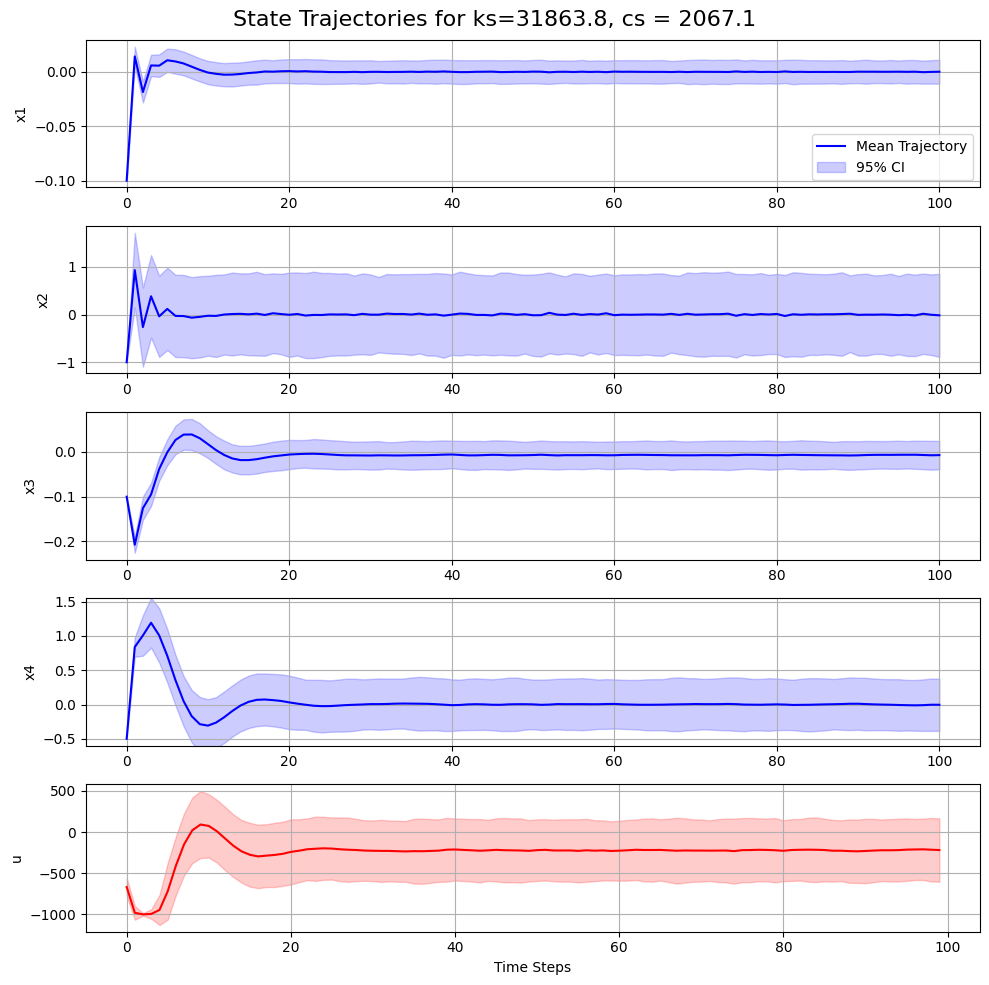

In [ ]:
from scipy.stats import sem, t

avg_score = np.average(score_total)
std_score = np.std(score_total)
print("Average Score: {:.3f}".format(avg_score))
print("Std of Score: {:.3f}".format(std_score))

mean_traj1 = np.mean(x_sys[:,:,0], axis=0)
mean_traj2 = np.mean(x_sys[:,:,1], axis=0)
mean_traj3 = np.mean(x_sys[:,:,2], axis=0)
mean_traj4 = np.mean(x_sys[:,:,3], axis=0)
mean_traj5 = np.mean(a_sys, axis=0)

# Calculate the standard deviation
sem_traj1 = np.std(x_sys[:,:,0], axis=0)
sem_traj2 = np.std(x_sys[:,:,1], axis=0)
sem_traj3 = np.std(x_sys[:,:,2], axis=0)
sem_traj4 = np.std(x_sys[:,:,3], axis=0)
sem_traj5 = np.std(a_sys, axis=0)

# Calculate the t critical value for 95% confidence interval
confidence = 0.95
n = x_sys.shape[0]  # number of trajectories
t_critical = t.ppf((1 + confidence) / 2., n - 1)

# Calculate the margin of error
margin_of_error1 = t_critical * sem_traj1
margin_of_error2 = t_critical * sem_traj2
margin_of_error3 = t_critical * sem_traj3
margin_of_error4 = t_critical * sem_traj4
margin_of_error5 = t_critical * sem_traj5

# Calculate the confidence interval
lower_bound1 = mean_traj1 - margin_of_error1
upper_bound1 = mean_traj1 + margin_of_error1
lower_bound2 = mean_traj2 - margin_of_error2
upper_bound2 = mean_traj2 + margin_of_error2
lower_bound3 = mean_traj3 - margin_of_error3
upper_bound3 = mean_traj3 + margin_of_error3
lower_bound4 = mean_traj4 - margin_of_error4
upper_bound4 = mean_traj4 + margin_of_error4
lower_bound5 = mean_traj5 - margin_of_error5
upper_bound5 = mean_traj5 + margin_of_error5

t_vec = np.arange(0, 101)

# Create the mean trajectories with 95% confidence interval
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(10, 10))

ax1.plot(t_vec, mean_traj1, color='b', label='Mean Trajectory')
ax1.fill_between(t_vec, lower_bound1, upper_bound1, color='b', alpha=0.2, label="95% CI")
# ax1.set_xlabel('Time Steps')
ax1.set_ylabel('x1')
# ax1.set_ylim((-3.75,1.0))
ax1.legend(loc='lower right')
ax1.grid(True)

ax2.plot(t_vec, mean_traj2, color='b', label='Mean Trajectory')
ax2.fill_between(t_vec, lower_bound2, upper_bound2, color='b', alpha=0.2, label="95% CI")
# ax2.set_xlabel('Time Steps')
ax2.set_ylabel('x2')
# ax2.set_ylim((-4,2))
ax2.grid(True)

ax3.plot(t_vec, mean_traj3, color='b', label='Mean Trajectory')
ax3.fill_between(t_vec, lower_bound3, upper_bound3, color='b', alpha=0.2, label="95% CI")
# ax3.set_xlabel('Time Steps')
ax3.set_ylabel('x3')
# ax3.set_ylim((-4,2))
ax3.grid(True)

ax4.plot(t_vec, mean_traj4, color='b', label='Mean Trajectory')
ax4.fill_between(t_vec, lower_bound4, upper_bound4, color='b', alpha=0.2, label="95% CI")
# ax4.set_xlabel('Time Steps')
ax4.set_ylabel('x4')
ax4.set_ylim((-0.6,1.55))
ax4.grid(True)

ax5.plot(t_vec[:-1], mean_traj5, color='r', label='Mean Trajectory')
ax5.fill_between(t_vec[:-1], lower_bound5, upper_bound5, color='r', alpha=0.2, label="95% CI")
ax5.set_xlabel('Time Steps')
ax5.set_ylabel('u')
ax5.grid(True)

plt.suptitle('State Trajectories for ks='+'{0:.1f}'.format(ks)+', cs = '+'{0:.1f}'.format(cs), fontsize=16)
plt.tight_layout()
plt.show()

## Generation 1 (load the dz/dt data)

In this stage, the system parameters $k_s$ and $c_s$ should be fixed, while only the control policy can be updated,

where the real system deviates from what we model by adding a nonlinear term, bias and uniform random variables for disturbances

The policy is retrained every 10 steps

In [136]:
dzdt = pd.read_csv("dz_dt_mild_driver1.csv")  # Speed profile for mild driver
dzdt = dzdt.to_numpy()
env = DynamicSystemEnv() # because we are going to use the real system in the env

## With RL updating

In [137]:
import copy
ks_1 = copy.deepcopy(ks) # after the first CCD optimization
cs_1 = copy.deepcopy(cs) # after the first CCD optimization
ks_normalized = (ks-env.ks_min)/(env.ks_max-env.ks_min)
cs_normalized = (cs-env.cs_min)/(env.cs_max-env.cs_min)
xmin_array = xmin.numpy()
xmax_array = xmax.numpy()

print_interval = 10
rollout = []
score_history = []
N_total = 15000
score = 0.0
print_interval = 10
temp_training_data = []
training_len = 10
s = env.reset_origin(ks_normalized,cs_normalized)
done = False
count = 0
x_sys = np.zeros((N_total+1,4))
a_sys = np.zeros((N_total,))
x_sys[0,:] = np.array([s[0],s[1],s[2],s[3]])

while count < N_total:
    x_tmp = np.append(s,ks)
    x_tmp = np.append(x_tmp,cs)
    s_normalized = (s - xmin_array[0][0:4]) / (xmax_array[0][0:4] - xmin_array[0][0:4])
    x = (x_tmp - xmin_array[0]) / (xmax_array[0] - xmin_array[0])
    normalized_inputs_tmp = torch.tensor(x.reshape(1,6), dtype=torch.float32)
    mu, std = model.pi(normalized_inputs_tmp)
    dist = Normal(mu, std)
    a = dist.sample()
    log_prob = dist.log_prob(a)
    action = min(max(a.item()*1000, env.action_space.low[0]), env.action_space.high[0])
    a_sys[count] = action
    s_prime, r, done, _ = env.step_real([action],dzdt[count],ks_normalized,cs_normalized)
    x_sys[count+1,:] = s_prime
    s_prime_normalized = (s_prime - xmin_array[0][0:4]) / (xmax_array[0][0:4] - xmin_array[0][0:4])
    rollout.append((s_normalized, action/1000, r/1000.0, s_prime_normalized, log_prob.item(), done))
    if len(rollout) == rollout_len:
        model.put_data(rollout)
        rollout = []
        model.train_net(ks,cs)

    s = s_prime

    score += r
    count += 1
    if count%print_interval==0:
        print("# of steps :{}, avg score : {:.4f}".format(count, score/print_interval))
        score = 0.0

env.close()

model_first_gen = copy.deepcopy(model) # save the model

# of steps :10, avg score : -0.0437
# of steps :20, avg score : -0.0695


/tmp/ipykernel_27646/1453459771.py:179: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ks_torch = torch.tensor(ks, requires_grad=True, dtype=torch.float32)
/tmp/ipykernel_27646/1453459771.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cs_torch = torch.tensor(cs, requires_grad=True, dtype=torch.float32)


# of steps :30, avg score : -0.0536
# of steps :40, avg score : -0.0461
# of steps :50, avg score : -0.0525
# of steps :60, avg score : -0.0490
# of steps :70, avg score : -0.0453
# of steps :80, avg score : -0.0641
# of steps :90, avg score : -0.0525
# of steps :100, avg score : -0.0556
# of steps :110, avg score : -0.0374
# of steps :120, avg score : -0.0544
# of steps :130, avg score : -0.0572
# of steps :140, avg score : -0.0523
# of steps :150, avg score : -0.0661
# of steps :160, avg score : -0.0537
# of steps :170, avg score : -0.0585
# of steps :180, avg score : -0.0488
# of steps :190, avg score : -0.0597
# of steps :200, avg score : -0.0609
# of steps :210, avg score : -0.0521
# of steps :220, avg score : -0.0690
# of steps :230, avg score : -0.0470
# of steps :240, avg score : -0.0691
# of steps :250, avg score : -0.6550
# of steps :260, avg score : -0.9176
# of steps :270, avg score : -0.0676
# of steps :280, avg score : -0.0419
# of steps :290, avg score : -0.0483
# of ste

Return for Generation 1 : -2830.7716


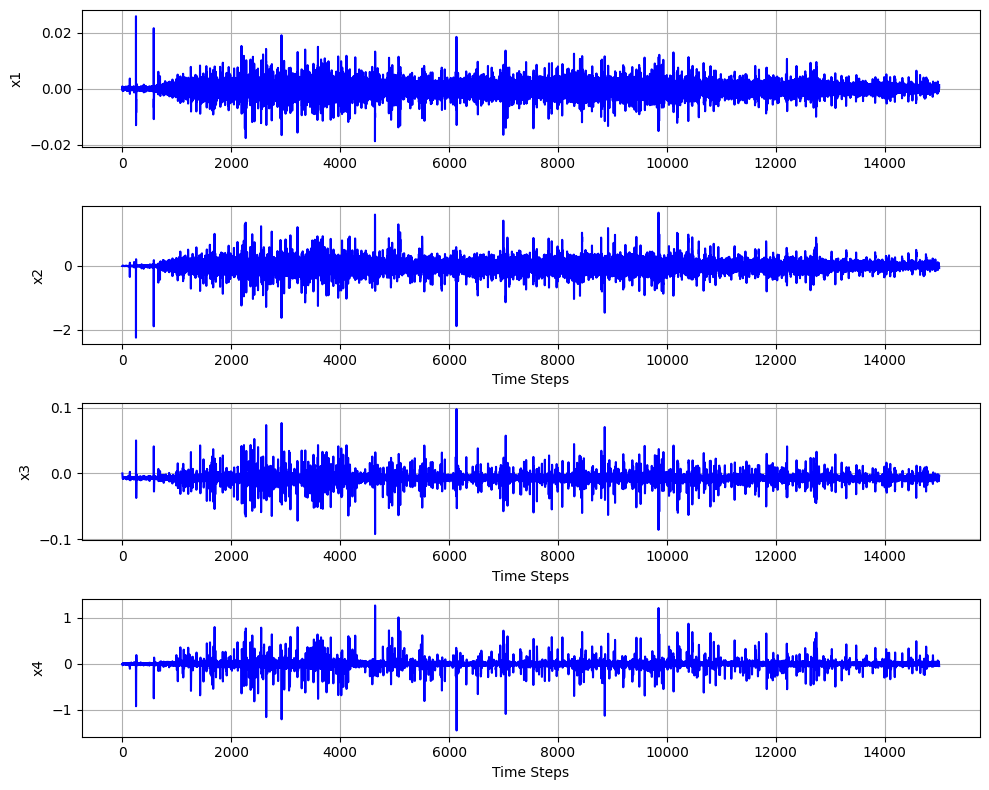

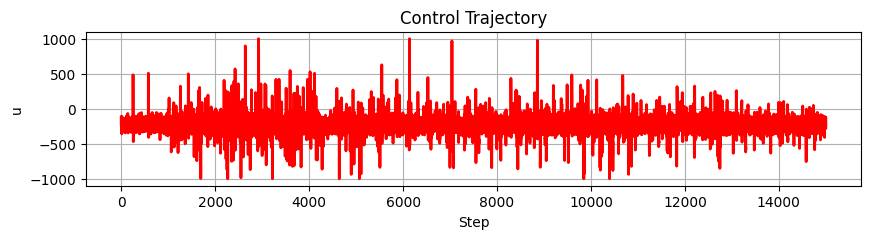

In [138]:
return_gen1 = 0
for i in range(1,15000):
    return_gen1 = return_gen1 - x_sys[i,:] @ env.Q @ x_sys[i,:].T - env.R * a_sys[i]**2
return_gen1 = return_gen1 - x_sys[-1,:] @ env.Q @ x_sys[-1,:].T
print("Return for Generation 1 : {:.4f}".format(return_gen1))

t_vec = np.arange(0, 15001)

# Create the mean trajectories with 95% confidence interval
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8))
ax1.plot(t_vec, x_sys[:,0], color='b', label='x1')
# ax1.set_xlabel('Time Steps')
ax1.set_ylabel('x1')
# ax1.set_ylim((-3.75,1.0))
# ax1.legend(loc='lower right')
ax1.grid(True)

ax2.plot(t_vec, x_sys[:,1], color='b', label='x2')
ax2.set_xlabel('Time Steps')
ax2.set_ylabel('x2')
# ax2.set_ylim((-4,2))
# ax2.legend(loc='lower right')
ax2.grid(True)


ax3.plot(t_vec, x_sys[:,2], color='b', label='x3')
ax3.set_xlabel('Time Steps')
ax3.set_ylabel('x3')
# ax3.set_ylim((-4,2))
# ax3.legend(loc='lower right')
ax3.grid(True)

ax4.plot(t_vec, x_sys[:,3], color='b', label='x4')
ax4.set_xlabel('Time Steps')
ax4.set_ylabel('x4')
# ax4.set_ylim((-4,2))
# ax4.legend(loc='lower right')
ax4.grid(True)

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 2))
plt.plot(t_vec[:-1], a_sys, label='u', color='r', linestyle='-', linewidth=2)

plt.title('Control Trajectory')
plt.xlabel('Step')
plt.ylabel('u')

plt.grid(True)
plt.show()


In [240]:
import pandas as pd

data_to_save_csv = pd.DataFrame(x_sys_wo_updating)
data_to_save_csv.to_csv("x_sys_gen1.csv", index=False, header=False)

data_to_save_csv = pd.DataFrame(a_sys_wo_updating)
data_to_save_csv.to_csv("a_sys_gen1.csv", index=False, header=False)

## Train a discrepany function for updated model

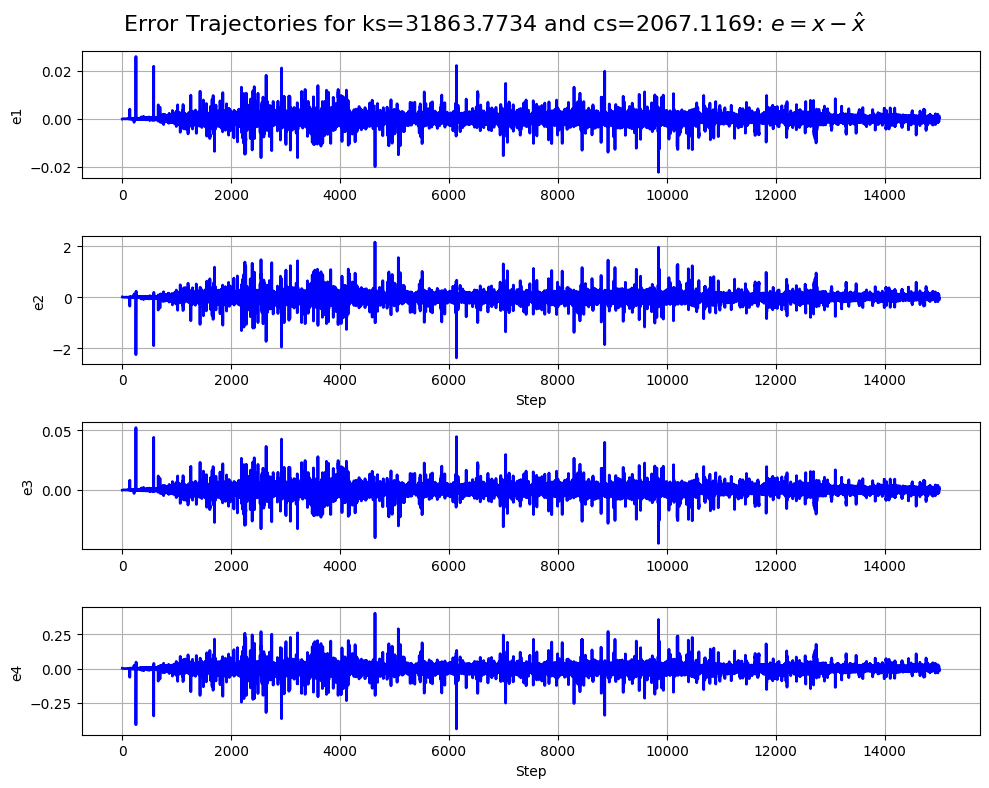

In [139]:
x1_input = x_sys[:-1,0]
x2_input = x_sys[:-1,1]
x3_input = x_sys[:-1,2]
x4_input = x_sys[:-1,3]

u_input = a_sys
x_nom = np.zeros((len(x_sys),4))
x_nom[0,:] = x_sys[0,:]
for i in range(len(x1_input)):
    x_nom[i+1,:] = np.dot(env.A, x_sys[i,:]) + np.dot(env.B, [a_sys[i]])

e1_input = x_sys[:-1,0]-x_nom[:-1,0]
e2_input = x_sys[:-1,1]-x_nom[:-1,1]
e3_input = x_sys[:-1,2]-x_nom[:-1,2]
e4_input = x_sys[:-1,3]-x_nom[:-1,3]
Input = np.stack((x1_input, x2_input, x3_input, x4_input, e1_input, e2_input, e3_input, e4_input, u_input), axis=0)
Output = x_sys[1:,:]-x_nom[1:,:]

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8))

ax1.plot(t_vec[1:], Output[:,0], label='e1', color='b', linestyle='-', linewidth=2)
ax1.set_ylabel('e1')
ax1.grid(True)

ax2.plot(t_vec[1:], Output[:,1], label='e2', color='b', linestyle='-', linewidth=2)
ax2.set_xlabel('Step')
ax2.set_ylabel('e2')
ax2.grid(True)

ax3.plot(t_vec[1:], Output[:,2], label='e1', color='b', linestyle='-', linewidth=2)
ax3.set_ylabel('e3')
ax3.grid(True)

ax4.plot(t_vec[1:], Output[:,3], label='e2', color='b', linestyle='-', linewidth=2)
ax4.set_xlabel('Step')
ax4.set_ylabel('e4')
ax4.grid(True)
fig.suptitle('Error Trajectories for ks='+'{0:.4f}'.format(ks)+' and cs='+'{0:.4f}'.format(cs)+': $e=x-\hat{x}$', fontsize=16)

plt.tight_layout()
plt.show()

In [140]:
from torch.utils.data import Dataset, DataLoader

class SurrogateDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class QuantileLoss(nn.Module):
    def __init__(self, quantiles):
        super().__init__()
        self.quantiles = quantiles

    def forward(self, preds, target):
        assert not target.requires_grad
        assert preds.size(0) == target.size(0)
        losses = []
        for i, q in enumerate(self.quantiles):
            errors = target - preds[:, i::len(self.quantiles)]
            losses.append(torch.max((q-1) * errors, q * errors).unsqueeze(1))
        loss = torch.mean(torch.sum(torch.cat(losses, dim=1), dim=1))
        return loss

class SurrogateModel(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims, quantiles):
        super().__init__()
        self.quantiles = quantiles
        layers = []
        prev_dim = input_dim
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.1))
            prev_dim = hidden_dim
        self.hidden_layers = nn.Sequential(*layers)
        self.output_layer = nn.Linear(prev_dim, output_dim * len(quantiles))

    def forward(self, x):
        x = self.hidden_layers(x)
        return self.output_layer(x)

from sklearn.model_selection import train_test_split

batch_size = 32
X_train, X_val, y_train, y_val = train_test_split(Input.T, Output, test_size=0.2, random_state=42)

# Create dataset and dataloader
dataset = SurrogateDataset(X_train, y_train)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

val_dataset = SurrogateDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=32)

In [143]:
# Hyperparameters
input_dim =  9
output_dim = 4
hidden_dims = [16, 32, 64, 128, 64, 32, 16]
quantiles = [0.1, 0.5, 0.9]
learning_rate = 0.001
batch_size = 32
num_epochs = 400

# Initialize model, loss, and optimizer
model_dysys = SurrogateModel(input_dim, output_dim, hidden_dims, quantiles)
criterion = QuantileLoss(quantiles)
optimizer = optim.Adam(model_dysys.parameters(), lr=learning_rate)

val_losses = []
# Training loop with loss tracking
epoch_losses = []
for epoch in range(num_epochs):
    model_dysys.train()
    total_loss = 0
    for batch_X, batch_y in dataloader:
        optimizer.zero_grad()
        outputs = model_dysys(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    # Validation
    model_dysys.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            inputs, targets = batch
            outputs = model_dysys(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
    
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    
    avg_loss = total_loss / len(dataloader)
    epoch_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Val Loss: {val_loss:.4f}")



Epoch [1/400], Loss: 0.0520, Val Loss: 0.0403
Epoch [2/400], Loss: 0.0417, Val Loss: 0.0398
Epoch [3/400], Loss: 0.0410, Val Loss: 0.0397
Epoch [4/400], Loss: 0.0409, Val Loss: 0.0397
Epoch [5/400], Loss: 0.0408, Val Loss: 0.0396
Epoch [6/400], Loss: 0.0406, Val Loss: 0.0394
Epoch [7/400], Loss: 0.0404, Val Loss: 0.0393
Epoch [8/400], Loss: 0.0402, Val Loss: 0.0391
Epoch [9/400], Loss: 0.0401, Val Loss: 0.0390
Epoch [10/400], Loss: 0.0401, Val Loss: 0.0389
Epoch [11/400], Loss: 0.0401, Val Loss: 0.0392
Epoch [12/400], Loss: 0.0400, Val Loss: 0.0389
Epoch [13/400], Loss: 0.0401, Val Loss: 0.0390
Epoch [14/400], Loss: 0.0400, Val Loss: 0.0388
Epoch [15/400], Loss: 0.0398, Val Loss: 0.0386
Epoch [16/400], Loss: 0.0393, Val Loss: 0.0380
Epoch [17/400], Loss: 0.0391, Val Loss: 0.0383
Epoch [18/400], Loss: 0.0386, Val Loss: 0.0373
Epoch [19/400], Loss: 0.0382, Val Loss: 0.0373
Epoch [20/400], Loss: 0.0377, Val Loss: 0.0368
Epoch [21/400], Loss: 0.0376, Val Loss: 0.0355
Epoch [22/400], Loss: 

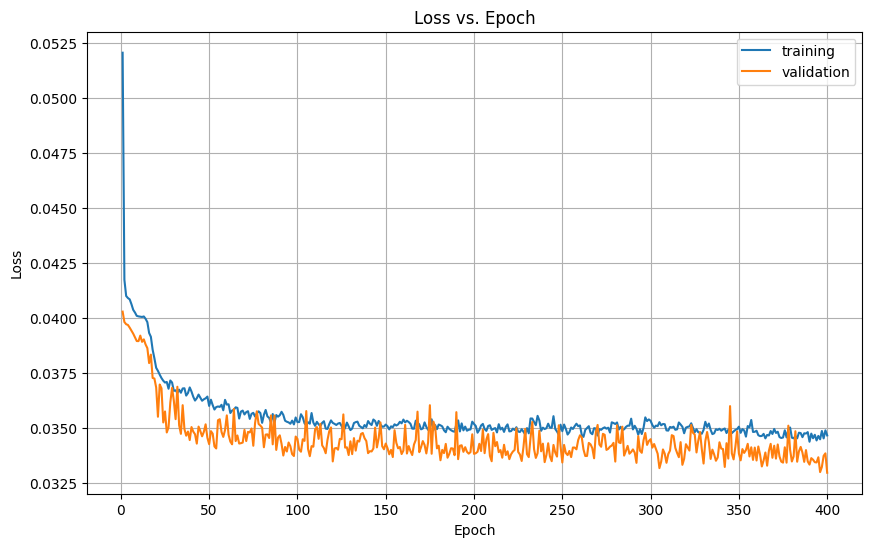

Prediction:
Output 1: [-0.001454225741326809, -0.0004945730324834585, 0.0006441826117224991]
Output 2: [-0.12164811044931412, 0.00870949774980545, 0.13281087577342987]
Output 3: [-0.002630983479321003, -0.0001485207030782476, 0.0016563954995945096]
Output 4: [-0.02186308242380619, 0.002184887183830142, 0.025654375553131104]


In [144]:
import matplotlib.pyplot as plt

# Plotting the loss vs epoch
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), epoch_losses, label='training')
plt.plot(range(1, num_epochs + 1), val_losses, label='validation')
plt.title('Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

# Example prediction (as before)
model_dysys.eval()
with torch.no_grad():
    prediction = model_dysys(torch.tensor(X_val[0,:], dtype=torch.float32))
    prediction = prediction.reshape(output_dim, len(quantiles))
    print("Prediction:")
    for i in range(output_dim):
        print(f"Output {i+1}: {prediction[i].tolist()}")

## Save the trained discrepancy function

In [ ]:
import pickle

variables_to_save = {
    'model_dysys': model_dysys
    # Add more variables as needed
}


with open('RL_PPO_CCD_susp_discrep_func.pkl', 'wb') as file:
    pickle.dump(variables_to_save, file)

In [ ]:
import pickle

with open('RL_PPO_CCD_susp_discrep_func.pkl', 'rb') as file:
    loaded_variables = pickle.load(file)
model_dysys = loaded_variables['model_dysys']

## Visualize

Initial state:[-0.100,-1.000,-0.100,-0.500]
Current state:[-0.100,-1.000,-0.100,-0.500], Action: -607.283, Next state:[0.014,0.886,-0.208,0.835]
Current state:[0.014,0.886,-0.208,0.835], Action: -1000.000, Next state:[-0.018,-0.199,-0.127,1.017]
Current state:[-0.018,-0.199,-0.127,1.017], Action: -1000.000, Next state:[0.006,-0.097,-0.096,1.112]
Current state:[0.006,-0.097,-0.096,1.112], Action: -1000.000, Next state:[0.004,-0.275,-0.042,0.852]
Current state:[0.004,-0.275,-0.042,0.852], Action: -969.492, Next state:[0.008,-0.192,-0.011,0.537]
Current state:[0.008,-0.192,-0.011,0.537], Action: -646.951, Next state:[0.006,-0.067,0.012,0.246]
Current state:[0.006,-0.067,0.012,0.246], Action: -313.299, Next state:[0.005,-0.012,0.020,0.055]
Current state:[0.005,-0.012,0.020,0.055], Action: -199.676, Next state:[0.003,-0.025,0.020,-0.081]
Current state:[0.003,-0.025,0.020,-0.081], Action: -74.576, Next state:[0.001,-0.022,0.016,-0.156]
Current state:[0.001,-0.022,0.016,-0.156], Action: -73.6

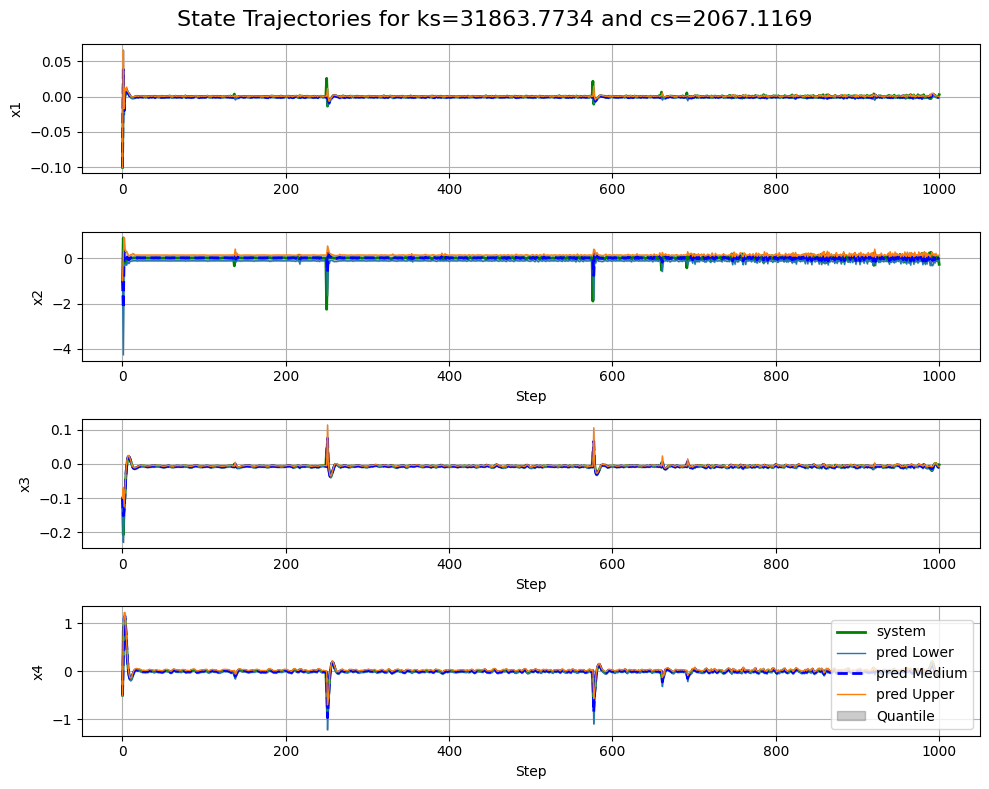

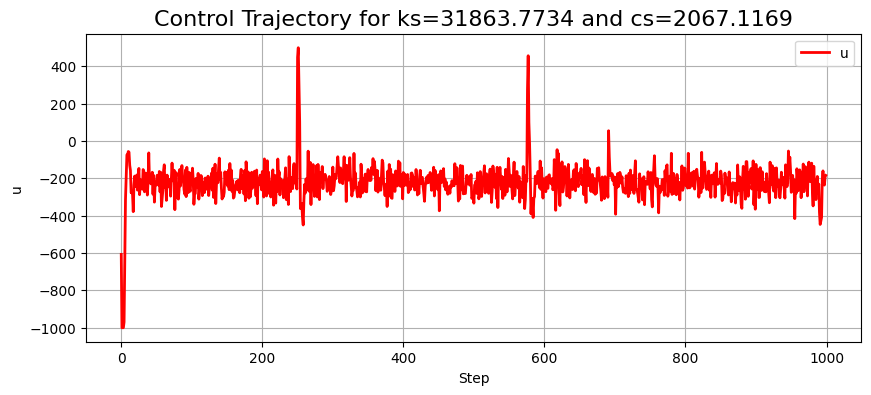

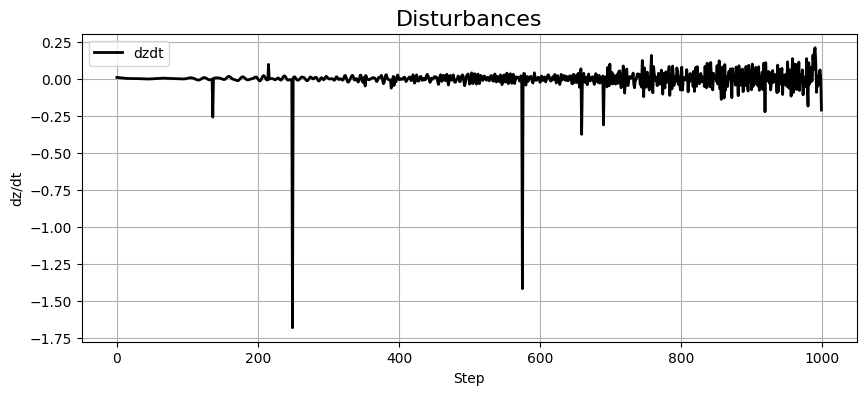

In [146]:
ks = copy.deepcopy(ks_1) # after the first CCD optimization
cs = copy.deepcopy(cs_1) # after the first CCD optimization
ks_normalized = (ks-env.ks_min)/(env.ks_max-env.ks_min)
cs_normalized = (cs-env.cs_min)/(env.cs_max-env.cs_min)
# model = copy.deepcopy(model_first_gen) # save the model (for back up)
env = DynamicSystemEnv()
N_total = 1000
s = env.reset(ks_normalized,cs_normalized)
print("Initial state:[{:.3f},{:.3f},{:.3f},{:.3f}]".format(s[0],s[1],s[2],s[3]))
score = 0
x_sys = np.zeros((N_total+1,4))
x_sys_pred_LB = np.zeros((N_total+1,4))
x_sys_pred = np.zeros((N_total+1,4))
x_sys_pred_UB = np.zeros((N_total+1,4))
a_sys = np.zeros((N_total,))
x_sys_pred_LB[0,:] = np.array([s[0],s[1],s[2],s[3]])
x_sys_pred[0,:] = np.array([s[0],s[1],s[2],s[3]])

x_sys_pred_UB[0,:] = np.array([s[0],s[1],s[2],s[3]])
x_sys[0,:] = np.array([s[0],s[1],s[2],s[3]])
for i in range(N_total):
    x_tmp = np.append(s,ks)
    x_tmp = np.append(x_tmp,cs)
    s_normalized = (s - xmin_array[0][0:4]) / (xmax_array[0][0:4] - xmin_array[0][0:4])
    x = (x_tmp - xmin_array[0]) / (xmax_array[0] - xmin_array[0])
    normalized_inputs_tmp = torch.tensor(x.reshape(1,6), dtype=torch.float32)
    mu, std = model.pi(normalized_inputs_tmp)
    dist = Normal(mu, std)
    a_tensor = dist.sample()
    a = min(max(a_tensor.item()*1000, env.action_space.low[0]), env.action_space.high[0])
    # a = min(max(mu.item(), env.action_space.low[0]), env.action_space.high[0])
    x_nom = np.dot(env.A, s.reshape(4,1)) + np.dot(env.B, a)
    e1 = s[0]-x_nom[0]
    e2 = s[1]-x_nom[1]
    e3 = s[2]-x_nom[2]
    e4 = s[3]-x_nom[3]
    s_prime, r, done, _ = env.step_real([a],dzdt[i],ks_normalized,cs_normalized)
    input_pred_model = np.array([s[0],s[1],s[2],s[3],e1[0],e2[0],e3[0],e4[0],a])
    s_prime_pred = model_dysys(torch.tensor(input_pred_model, dtype=torch.float32))
    s_prime_pred_numpy = s_prime_pred.detach().numpy()

    x_sys[i+1,:] = s_prime
    x_sys_pred_LB[i+1,:] = x_nom[:,0] + np.array([s_prime_pred_numpy[0],s_prime_pred_numpy[3],s_prime_pred_numpy[6],s_prime_pred_numpy[9]])
    x_sys_pred[i+1,:] = x_nom[:,0] + np.array([s_prime_pred_numpy[1],s_prime_pred_numpy[4],s_prime_pred_numpy[7],s_prime_pred_numpy[10]])
    x_sys_pred_UB[i+1,:] = x_nom[:,0] + np.array([s_prime_pred_numpy[2],s_prime_pred_numpy[5],s_prime_pred_numpy[8],s_prime_pred_numpy[11]])
    a_sys[i] = a
    score += r
    print("Current state:[{:.3f},{:.3f},{:.3f},{:.3f}], Action: {:.3f}, Next state:[{:.3f},{:.3f},{:.3f},{:.3f}]".format(s[0],s[1],s[2],s[3],a,s_prime[0],s_prime[1],s_prime[2],s_prime[3]))
    s = s_prime

t = np.arange(0, N_total+1)
# Create the plot
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8))

ax1.plot(t, x_sys[:,0], label='system', color='g', linestyle='-', linewidth=2)
ax1.plot(t, x_sys_pred_LB[:,0], label='pred Lower', linestyle='-', linewidth=1)
ax1.plot(t, x_sys_pred[:,0], label='pred Medium', color='b', linestyle='--', linewidth=2)
ax1.plot(t, x_sys_pred_UB[:,0], label='pred Upper', linestyle='-', linewidth=1)
ax1.fill_between(t, x_sys_pred_LB[:,0], x_sys_pred_UB[:,0], color='k', alpha=0.2, label="Quantile")
ax1.set_ylabel('x1')
ax1.grid(True)


ax2.plot(t, x_sys[:,1], label='system', color='g', linestyle='-', linewidth=2)
ax2.plot(t, x_sys_pred_LB[:,1], label='pred Lower', linestyle='-', linewidth=1)
ax2.plot(t, x_sys_pred[:,1], label='pred Medium', color='b', linestyle='--', linewidth=2)
ax2.plot(t, x_sys_pred_UB[:,1], label='pred Upper', linestyle='-', linewidth=1)
ax2.fill_between(t, x_sys_pred_LB[:,1], x_sys_pred_UB[:,1], color='k', alpha=0.2, label="Quantile")
ax2.set_xlabel('Step')
ax2.set_ylabel('x2')
ax2.grid(True)

ax3.plot(t, x_sys[:,2], label='system', color='g', linestyle='-', linewidth=2)
ax3.plot(t, x_sys_pred_LB[:,2], label='pred Lower', linestyle='-', linewidth=1)
ax3.plot(t, x_sys_pred[:,2], label='pred Medium', color='b', linestyle='--', linewidth=2)
ax3.plot(t, x_sys_pred_UB[:,2], label='pred Upper', linestyle='-', linewidth=1)
ax3.fill_between(t, x_sys_pred_LB[:,2], x_sys_pred_UB[:,2], color='k', alpha=0.2, label="Quantile")
ax3.set_xlabel('Step')
ax3.set_ylabel('x3')
ax3.grid(True)

ax4.plot(t, x_sys[:,3], label='system', color='g', linestyle='-', linewidth=2)
ax4.plot(t, x_sys_pred_LB[:,3], label='pred Lower', linestyle='-', linewidth=1)
ax4.plot(t, x_sys_pred[:,3], label='pred Medium', color='b', linestyle='--', linewidth=2)
ax4.plot(t, x_sys_pred_UB[:,3], label='pred Upper', linestyle='-', linewidth=1)
ax4.fill_between(t, x_sys_pred_LB[:,3], x_sys_pred_UB[:,3], color='k', alpha=0.2, label="Quantile")
ax4.set_xlabel('Step')
ax4.set_ylabel('x4')
ax4.grid(True)
ax4.legend(loc="lower right")
fig.suptitle('State Trajectories for ks='+'{0:.4f}'.format(ks)+' and cs='+'{0:.4f}'.format(cs), fontsize=16)
plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 4))
plt.plot(t[:-1], a_sys, label='u', color='r', linestyle='-', linewidth=2)

plt.title('Control Trajectory for ks='+'{0:.4f}'.format(ks)+' and cs='+'{0:.4f}'.format(cs), fontsize=16)
plt.xlabel('Step')
plt.ylabel('u')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(t[:-1], dzdt[0:N_total], label='dzdt', color='k', linestyle='-', linewidth=2)

plt.title('Disturbances', fontsize=16)
plt.xlabel('Step')
plt.ylabel('dz/dt')
plt.legend()
plt.grid(True)
plt.show()

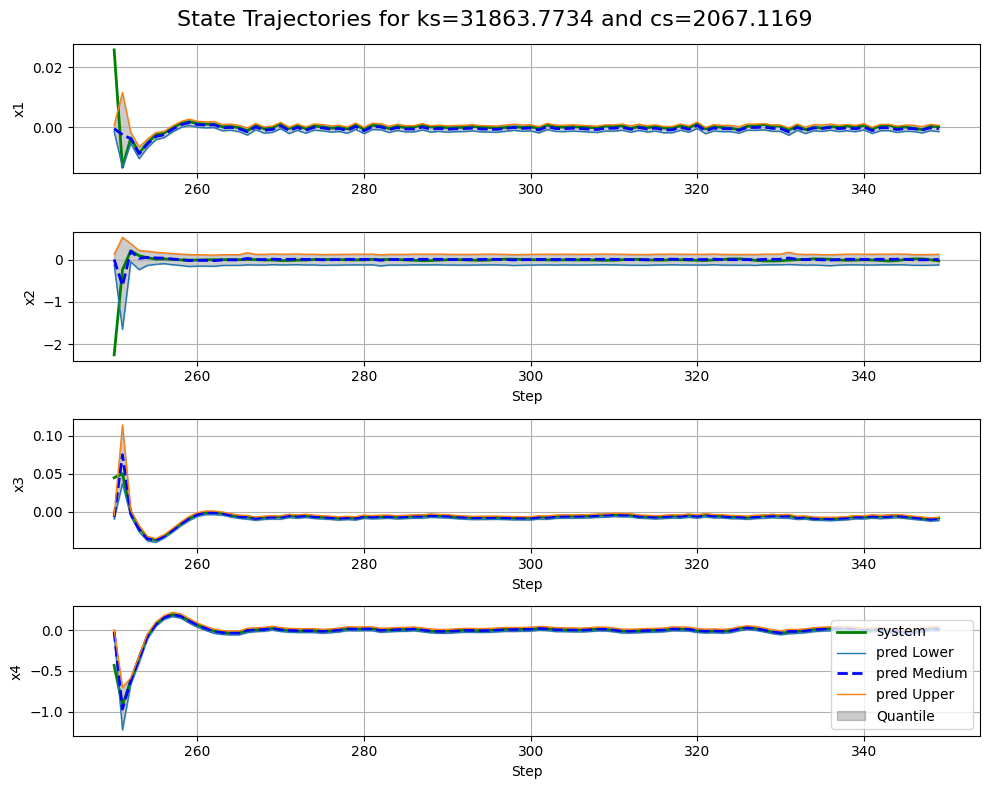

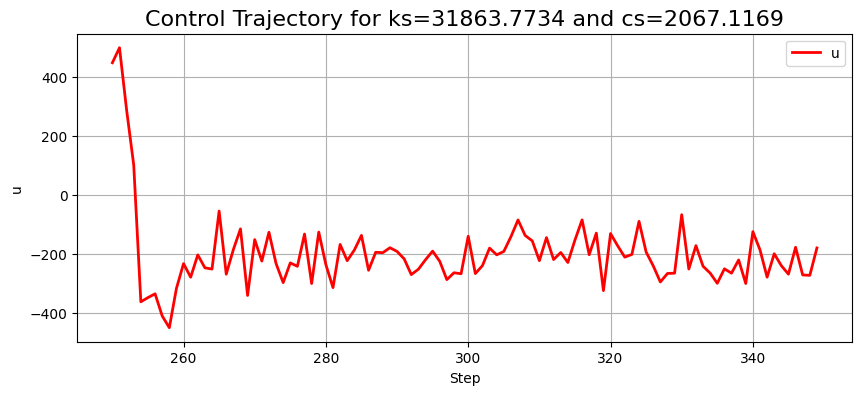

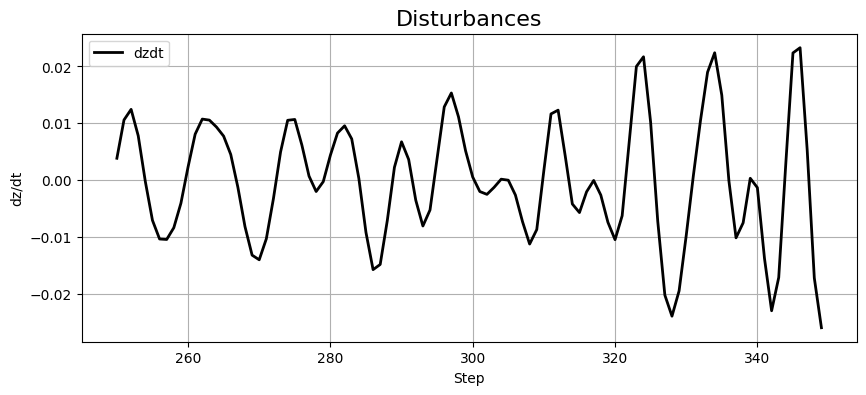

In [148]:
start_point = 250
end_point = 350
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8))

ax1.plot(t[start_point:end_point], x_sys[start_point:end_point,0], label='system', color='g', linestyle='-', linewidth=2)
ax1.plot(t[start_point:end_point], x_sys_pred_LB[start_point:end_point,0], label='pred Lower', linestyle='-', linewidth=1)
ax1.plot(t[start_point:end_point], x_sys_pred[start_point:end_point,0], label='pred Medium', color='b', linestyle='--', linewidth=2)
ax1.plot(t[start_point:end_point], x_sys_pred_UB[start_point:end_point,0], label='pred Upper', linestyle='-', linewidth=1)
ax1.fill_between(t[start_point:end_point], x_sys_pred_LB[start_point:end_point,0], x_sys_pred_UB[start_point:end_point,0], color='k', alpha=0.2, label="Quantile")
ax1.set_ylabel('x1')
ax1.grid(True)


ax2.plot(t[start_point:end_point], x_sys[start_point:end_point,1], label='system', color='g', linestyle='-', linewidth=2)
ax2.plot(t[start_point:end_point], x_sys_pred_LB[start_point:end_point,1], label='pred Lower', linestyle='-', linewidth=1)
ax2.plot(t[start_point:end_point], x_sys_pred[start_point:end_point,1], label='pred Medium', color='b', linestyle='--', linewidth=2)
ax2.plot(t[start_point:end_point], x_sys_pred_UB[start_point:end_point,1], label='pred Upper', linestyle='-', linewidth=1)
ax2.fill_between(t[start_point:end_point], x_sys_pred_LB[start_point:end_point,1], x_sys_pred_UB[start_point:end_point,1], color='k', alpha=0.2, label="Quantile")
ax2.set_xlabel('Step')
ax2.set_ylabel('x2')
ax2.grid(True)

ax3.plot(t[start_point:end_point], x_sys[start_point:end_point,2], label='system', color='g', linestyle='-', linewidth=2)
ax3.plot(t[start_point:end_point], x_sys_pred_LB[start_point:end_point,2], label='pred Lower', linestyle='-', linewidth=1)
ax3.plot(t[start_point:end_point], x_sys_pred[start_point:end_point,2], label='pred Medium', color='b', linestyle='--', linewidth=2)
ax3.plot(t[start_point:end_point], x_sys_pred_UB[start_point:end_point,2], label='pred Upper', linestyle='-', linewidth=1)
ax3.fill_between(t[start_point:end_point], x_sys_pred_LB[start_point:end_point,2], x_sys_pred_UB[start_point:end_point,2], color='k', alpha=0.2, label="Quantile")
ax3.set_xlabel('Step')
ax3.set_ylabel('x3')
ax3.grid(True)

ax4.plot(t[start_point:end_point], x_sys[start_point:end_point,3], label='system', color='g', linestyle='-', linewidth=2)
ax4.plot(t[start_point:end_point], x_sys_pred_LB[start_point:end_point,3], label='pred Lower', linestyle='-', linewidth=1)
ax4.plot(t[start_point:end_point], x_sys_pred[start_point:end_point,3], label='pred Medium', color='b', linestyle='--', linewidth=2)
ax4.plot(t[start_point:end_point], x_sys_pred_UB[start_point:end_point,3], label='pred Upper', linestyle='-', linewidth=1)
ax4.fill_between(t[start_point:end_point], x_sys_pred_LB[start_point:end_point,3], x_sys_pred_UB[start_point:end_point,3], color='k', alpha=0.2, label="Quantile")
ax4.set_xlabel('Step')
ax4.set_ylabel('x4')
ax4.grid(True)
ax4.legend(loc="lower right")
fig.suptitle('State Trajectories for ks='+'{0:.4f}'.format(ks)+' and cs='+'{0:.4f}'.format(cs), fontsize=16)
plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 4))
plt.plot(t[start_point:end_point], a_sys[start_point:end_point], label='u', color='r', linestyle='-', linewidth=2)

plt.title('Control Trajectory for ks='+'{0:.4f}'.format(ks)+' and cs='+'{0:.4f}'.format(cs), fontsize=16)
plt.xlabel('Step')
plt.ylabel('u')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(t[start_point:end_point], dzdt[start_point:end_point], label='dzdt', color='k', linestyle='-', linewidth=2)

plt.title('Disturbances', fontsize=16)
plt.xlabel('Step')
plt.ylabel('dz/dt')
plt.legend()
plt.grid(True)
plt.show()

## Redefine the updated model (the original digital model + trained discrepancy function)
In this section, we need to update the model by adding the trained discrepancy function to the digital model.

In [ ]:
class DynamicSystemEnv2(gym.Env):
    def __init__(self):

        self.T = 0.05
        self.kus = 232.5e3
        self.mus = 65
        self.ms = 325
        self.ks = 27692.0
        self.cs = 1906.5
        self.ct = 0
        self.ks_max = 40000
        self.ks_min = 10000
        self.cs_max = 3000
        self.cs_min = 500

        A, B, Gd = self.sys_matrices()
        self.A = A
        self.B = B
        self.Gd = Gd

        # System dynamics parameters
        self.Q = np.array([[10,0,0,0], [0,1,0,0], [0,0,50,0], [0,0,0,5]])     # State cost matrix
        self.R = 0.000001                                 # Action cost
        
        # State and action spaces
        self.observation_space = spaces.Box(low=-2.5, high=2.5, shape=(4,), dtype=np.float32)
        self.action_space = spaces.Box(low=-1000, high=1000, shape=(1,), dtype=np.float32)
        
        # Initial state
        self.state = np.array([-0.1,-1,-0.1,-0.5])
        
        # Maximum episode steps
        self.max_steps = 100
        self.current_step = 0
    
    def sys_matrices(self):
        Ac = np.array([[0,1,0,0], [-self.kus/self.mus,-self.cs/self.mus,self.ks/self.mus,self.cs/self.mus],[0,-1,0,1],[0,self.cs/self.ms,-self.ks/self.ms,-self.cs/self.ms]])
        Bc = np.array([[0],[-1/self.mus],[0],[1/self.ms]])
        Gc = np.array([[-1],[self.ct/self.mus],[0],[0]])
        def funB(t):
            return expm(Ac * t) @ Bc

        def funG(t):
            return expm(Ac * t) @ Gc

        A = expm(Ac * self.T)
        B = quad_vec(funB, 0, self.T)
        B = B[0]
        Gd = quad_vec(funG, 0, self.T)
        Gd = Gd[0]
        return A, B, Gd

    def step(self, action, ks_normalized, cs_normalized):
        ks = ks_normalized*(self.ks_max-self.ks_min)+self.ks_min
        cs = cs_normalized*(self.cs_max-self.cs_min)+self.cs_min
        self.ks = ks
        self.cs = cs

        A, B, Gd = self.sys_matrices()
        self.A = A
        self.B = B
        self.Gd = Gd

        # Clip action to stay within action bounds
        action = np.clip(action, self.action_space.low, self.action_space.high)
        
        # Update state based on system dynamics
        x = self.state
        e1 = x[0]-x_nom[0][0]
        e2 = x[1]-x_nom[1][0]
        e3 = x[2]-x_nom[2][0]
        e4 = x[3]-x_nom[3][0]

        # Add discrepancy function
        input_pred_model = np.array([x[0],x[1],x[2],x[3],e1,e2,e3,e4,action[0]])
        s_prime_pred = model_dysys(torch.tensor(input_pred_model, dtype=torch.float32))
        s_prime_pred_numpy = s_prime_pred.detach().numpy()
        x_nom_next = np.dot(self.A, x) + np.dot(self.B, action)
        x_next_pred_LB = x_nom_next + np.array([s_prime_pred_numpy[0],s_prime_pred_numpy[3],s_prime_pred_numpy[6],s_prime_pred_numpy[9]])
        x_next = x_nom_next + np.array([s_prime_pred_numpy[1],s_prime_pred_numpy[4],s_prime_pred_numpy[7],s_prime_pred_numpy[10]])
        x_next_pred_UB = x_nom_next + np.array([s_prime_pred_numpy[2],s_prime_pred_numpy[5],s_prime_pred_numpy[8],s_prime_pred_numpy[11]])
        Delta_x_next_quantile = x_next_pred_UB-x_next_pred_LB
        
        # Calculate reward
        Qq = self.Q*0.1
        reward = -x_next@self.Q@x_next.T - self.R * action**2 - Delta_x_next_quantile@Qq@Delta_x_next_quantile.T  
                
        # Update state
        self.state = x_next
        
        # Check if done
        done = (self.current_step >= self.max_steps) or (self.state[0]**2+self.state[1]**2+self.state[2]**2+self.state[3]**2<=0.01)
        self.current_step += 1
        
        return self.state, reward[0], done, {}
    
    def reset(self,ks_normalized,cs_normalized):
        # Reset state to initial value
        ks = ks_normalized*(self.ks_max-self.ks_min)+self.ks_min
        cs = cs_normalized*(self.cs_max-self.cs_min)+self.cs_min
        self.ks = ks
        self.cs = cs
        A, B, Gd = self.sys_matrices()
        self.A = A
        self.B = B
        self.Gd = Gd
        self.state = np.array([-0.1,-1,-0.1,-0.5])
        self.current_step = 0
        return self.state
    
    def render(self, mode='human'):
        pass

    def close(self):
        pass

## Take out the weights and biases from a pretrained policy

In [ ]:
model_parameter1 = list(model.fc1.parameters())
model_parameter2 = list(model.fc2.parameters())
model_parameter3 = list(model.fc3.parameters())
model_parameter4 = list(model.fc4.parameters())
model_parameter_mu = list(model.fc_mu.parameters())
model_parameter5 = list(model.fc5.parameters())
model_parameter6 = list(model.fc6.parameters())
model_parameter7 = list(model.fc7.parameters())
model_parameter8 = list(model.fc8.parameters())
model_parameter_std = list(model.fc_std.parameters())
model_parameter9 = list(model.fc5.parameters())
model_parameter10 = list(model.fc6.parameters())
model_parameter11 = list(model.fc7.parameters())
model_parameter12 = list(model.fc8.parameters())
model_parameter_v = list(model.fc_v.parameters())

## Define a PPO class again

In [ ]:
#Hyperparameters
learning_rate       = 0.00001
learning_rate_plant = 0.00001
gamma               = 1
lmbda               = 0.9
eps_clip            = 0.2
K_epoch             = 20
rollout_len         = 20
buffer_size         = 10
minibatch_size      = 32

class PPO_num2(nn.Module):
    def __init__(self):
        super(PPO_num, self).__init__()
        self.data = []
        
        self.fc1 = nn.Linear(6, 16)
        self.fc2 = nn.Linear(16, 32)
        self.fc3 = nn.Linear(32, 32)
        self.fc4 = nn.Linear(32, 16)
        self.fc_mu = nn.Linear(16, 1)

        self.fc5 = nn.Linear(6, 16)
        self.fc6 = nn.Linear(16, 32)
        self.fc7 = nn.Linear(32, 32)
        self.fc8 = nn.Linear(32, 16)
        self.fc_std  = nn.Linear(16, 1)

        self.fc9   = nn.Linear(6, 16)
        self.fc10  = nn.Linear(16, 32)
        self.fc11  = nn.Linear(32, 32)
        self.fc12  = nn.Linear(32, 16)
        self.fc_v  = nn.Linear(16, 1)

        with torch.no_grad():
            # Weights and bias for policy function (mean)
            self.fc1.weight.copy_(model_parameter[0])
            self.fc1.bias.copy_(model_parameter[1])
            self.fc2.weight.copy_(model_parameter[2])
            self.fc2.bias.copy_(model_parameter[3])
            self.fc3.weight.copy_(model_parameter[4])
            self.fc3.bias.copy_(model_parameter[5])
            self.fc4.weight.copy_(model_parameter[6])
            self.fc4.bias.copy_(model_parameter[7])
            self.fc_mu.weight.copy_(model_parameter[8])
            self.fc_mu.bias.copy_(model_parameter[9])

            # Weights and bias for policy function (std)
            self.fc5.weight.copy_(torch.zeros(16, 6))
            self.fc5.bias.copy_(torch.ones(16,)*0.01)
            self.fc6.weight.copy_(torch.zeros(32, 16))
            self.fc6.bias.copy_(torch.ones(32,)*0.01)
            self.fc7.weight.copy_(torch.zeros(32, 32))
            self.fc7.bias.copy_(torch.ones(32,)*0.01)
            self.fc8.weight.copy_(torch.zeros(16,32))
            self.fc8.bias.copy_(torch.ones(16,)*0.01)
            self.fc_std.weight.copy_(torch.zeros(16,))
            self.fc_std.bias.copy_(torch.ones(1,)*0.1)

            # Weights and bias for value function
            self.fc9.weight.copy_(model_value_parameter[0])
            self.fc9.bias.copy_(model_value_parameter[1])
            self.fc10.weight.copy_(model_value_parameter[2])
            self.fc10.bias.copy_(model_value_parameter[3])
            self.fc11.weight.copy_(model_value_parameter[4])
            self.fc11.bias.copy_(model_value_parameter[5])
            self.fc12.weight.copy_(model_value_parameter[6])
            self.fc12.bias.copy_(model_value_parameter[7])
            self.fc_v.weight.copy_(model_value_parameter[8])
            self.fc_v.bias.copy_(model_value_parameter[9])

        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate, weight_decay=1e-4)
        self.optimization_step = 0

    def pi(self, x, max_value = 0.5):
        Tanh_fuc = nn.Tanh()
        Softplus_fuc= nn.Softplus(beta=100) # To avoid negative value for std
        f1 = self.fc1(x)
        f2 = self.fc2(Tanh_fuc(f1))
        f3 = self.fc3(f2)
        f4 = self.fc4(Tanh_fuc(f3))
        mu = self.fc_mu(f4)
        
        f5 = self.fc5(x)
        f6 = self.fc6(Tanh_fuc(f5))
        f7 = self.fc7(f6)
        f8 = self.fc8(Tanh_fuc(f7))
        std = torch.min(Softplus_fuc(self.fc_std(f8)), torch.tensor(max_value))
        return mu, std
    
    def v(self, x):
        Tanh_fuc = nn.Tanh()
        f9 = self.fc9(x)
        f10 = self.fc10(Tanh_fuc(f9))
        f11 = self.fc11(f10)
        f12 = self.fc12(Tanh_fuc(f11))
        v = self.fc_v(f12)
        return v
      
    def put_data(self, transition):
        self.data.append(transition)
        
    def make_batch(self):
        s_batch, a_batch, r_batch, s_prime_batch, prob_a_batch, done_batch = [], [], [], [], [], []
        data = []

        for j in range(buffer_size):
            for i in range(minibatch_size):
                rollout = self.data.pop()
                s_lst, a_lst, r_lst, s_prime_lst, prob_a_lst, done_lst = [], [], [], [], [], []

                for transition in rollout:
                    s, a, r, s_prime, prob_a, done = transition
                    
                    s_lst.append(s)
                    a_lst.append([a])
                    r_lst.append([r])
                    s_prime_lst.append(s_prime)
                    prob_a_lst.append([prob_a])
                    done_mask = 0 if done else 1
                    done_lst.append([done_mask])

                s_batch.append(s_lst)
                a_batch.append(a_lst)
                r_batch.append(r_lst)
                s_prime_batch.append(s_prime_lst)
                prob_a_batch.append(prob_a_lst)
                done_batch.append(done_lst)
                    
            mini_batch = torch.tensor(s_batch, dtype=torch.float), torch.tensor(a_batch, dtype=torch.float), \
                          torch.tensor(r_batch, dtype=torch.float), torch.tensor(s_prime_batch, dtype=torch.float), \
                          torch.tensor(done_batch, dtype=torch.float), torch.tensor(prob_a_batch, dtype=torch.float)
            data.append(mini_batch)

        return data

    def calc_advantage(self, data, ks = 27692.0, cs = 1906.5):
        data_with_adv = []
        for mini_batch in data:
            s, a, r, s_prime, done_mask, old_log_prob = mini_batch
            with torch.no_grad():
                tensor_size = torch.Tensor.size(s_prime)
                new_tensor1 = torch.full((tensor_size[0],tensor_size[1],1), ks)
                new_tensor2 = torch.full((tensor_size[0],tensor_size[1],1), cs)
                # Concatenate the original tensor and the new tensor along the last dimension
                x = torch.cat((s, new_tensor1, new_tensor2), dim=2)
                x_normalized = (x-xmin)/(xmax-xmin)
                x_normalized = x_normalized.type(torch.float32)
                x_prime = torch.cat((s_prime, new_tensor1, new_tensor2), dim=2)
                x_prime_normalized = (x_prime-xmin)/(xmax-xmin)
                x_prime_normalized = x_prime_normalized.type(torch.float32)
                td_target = r + gamma * self.v(x_prime_normalized)
                delta = td_target - self.v(x_normalized)
            delta = delta.numpy()

            advantage_lst = []
            advantage = 0.0
            for delta_t in delta[::-1]:
                advantage = gamma * lmbda * advantage + delta_t[0]
                advantage_lst.append([advantage])
            advantage_lst.reverse()
            advantage = torch.tensor(advantage_lst, dtype=torch.float)
            data_with_adv.append((s, a, r, s_prime, done_mask, old_log_prob, td_target, advantage))

        return data_with_adv


    def train_net(self,ks,cs):
        global ks_torch, cs_torch
        ks_torch = torch.tensor(ks, requires_grad=True, dtype=torch.float32)
        cs_torch = torch.tensor(cs, requires_grad=True, dtype=torch.float32)
        if len(self.data) == minibatch_size * buffer_size:
            data = self.make_batch()
            data = self.calc_advantage(data,ks,cs)

            for i in range(K_epoch):
                for mini_batch in data:
                    s, a, r, s_prime, done_mask, old_log_prob, td_target, advantage = mini_batch
                    # compute the loss and gradient
                    tensor_size = torch.Tensor.size(s)
                    # new_tensor = torch.full((tensor_size[0],tensor_size[1],1), p_torch_in)
                    new_tensor1 = ks_torch.expand(tensor_size[0], tensor_size[1], 1)
                    new_tensor2 = cs_torch.expand(tensor_size[0], tensor_size[1], 1)
                    # Concatenate the original tensor and the new tensor along the last dimension
                    x = torch.cat((s, new_tensor1, new_tensor2), dim=2)
                    x_normalized = (x-xmin)/(xmax-xmin)
                    x_normalized = x_normalized.type(torch.float32)
                    mu, std = self.pi(x_normalized, max_value=0.5)
                    dist = Normal(mu, std)
                    log_prob = dist.log_prob(a)
                    ratio = torch.exp(log_prob - old_log_prob)  # a/b == exp(log(a)-log(b))

                    surr1 = ratio * advantage
                    surr2 = torch.clamp(ratio, 1-eps_clip, 1+eps_clip) * advantage
                    # clamp function ensures ratio is within the range
                    loss = -torch.min(surr1, surr2) + F.smooth_l1_loss(self.v(x_normalized) , td_target)
                    # compute the Smooth L1 loss, which is less sensitive to outliers than the MSE loss

                    self.optimizer.zero_grad()
                    loss.mean().backward() # compute the gradients of the loss with respect to the model parameters
                    nn.utils.clip_grad_norm_(self.parameters(), 1.0) # clip the gradients' norm to prevent the exploding gradient problem, clipped to a maximum of 1.0 in this case
                    self.optimizer.step() # update the model parameters using the gradients computed during backpropagation
                    self.optimization_step += 1

    def train_net_CCD(self,ks,cs): # co-optimizing policy and the system parameter p
        global p_torch
        ks_torch = torch.tensor(ks, dtype=torch.float32)
        cs_torch = torch.tensor(cs, dtype=torch.float32)
        tensor_list = [(ks_torch-xmin[0,4])/(xmax[0,4]-xmin[0,4]),(cs_torch-xmin[0,5])/(xmax[0,5]-xmin[0,5])]
        p_torch = torch.tensor([t.item() for t in tensor_list], dtype=torch.float64, requires_grad=True) # Convert the list of tensors into a single tensor
        if len(self.data) == minibatch_size * buffer_size:
            data = self.make_batch()
            data = self.calc_advantage(data,ks,cs)
            # optimizer_p = torch.optim.SGD([p_torch], lr=0.001) # define the optimizer that only updates p
            optimizer_p = torch.optim.Adam([p_torch], lr=learning_rate_plant, weight_decay=1e-4) # define the optimizer that only updates p; 'weight_decay' can help with overfitting

            for i in range(K_epoch):
                for mini_batch in data:
                    s, a, r, s_prime, done_mask, old_log_prob, td_target, advantage = mini_batch
                    # compute the loss and gradient
                    tensor_size = torch.Tensor.size(s)
                    new_tensor1 = p_torch[0].expand(tensor_size[0], tensor_size[1], 1)
                    new_tensor2 = p_torch[1].expand(tensor_size[0], tensor_size[1], 1)
                    # Concatenate the original tensor and the new tensor along the last dimension
                    x_normalized = torch.cat((s, new_tensor1, new_tensor2), dim=2)
                    # x = torch.cat((s, new_tensor1, new_tensor2), dim=2)
                    # x_normalized = (x-xmin)/(xmax-xmin)
                    x_normalized = x_normalized.type(torch.float32)
                    mu, std = self.pi(x_normalized, max_value=0.5)
                    dist = Normal(mu, std)
                    log_prob = dist.log_prob(a)
                    ratio = torch.exp(log_prob - old_log_prob)  # a/b == exp(log(a)-log(b))

                    surr1 = ratio * advantage
                    surr2 = torch.clamp(ratio, 1-eps_clip, 1+eps_clip) * advantage
                    # clamp function ensures ratio is within the range
                    loss = -torch.min(surr1, surr2) + F.smooth_l1_loss(self.v(x_normalized) , td_target)
                    # compute the Smooth L1 loss, which is less sensitive to outliers than the MSE loss

                    # autograd
                    optimizer_p.zero_grad()
                    loss.mean().backward(retain_graph=True) # Perform backward pass to compute gradients
                    optimizer_p.step()
                    # print(p_torch)

                    self.optimizer.zero_grad()
                    loss.mean().backward() # compute the gradients of the loss with respect to the model parameters
                    nn.utils.clip_grad_norm_(self.parameters(), 1.0) # clip the gradients' norm to prevent the exploding gradient problem, clipped to a maximum of 1.0 in this case
                    self.optimizer.step() # update the model parameters using the gradients computed during backpropagation
                    self.optimization_step += 1
        return p_torch[0], p_torch[1]


## CCD before Generation 2 (Second CCD optimization)

In [152]:
import copy

model2 = copy.deepcopy(model)
env2 = DynamicSystemEnv2()
xmin_array = xmin.numpy()
xmax_array = xmax.numpy()

ks = copy.deepcopy(ks_1) # after the first CCD optimization
cs = copy.deepcopy(cs_1) # after the first CCD optimization
ks_normalized = (ks-env2.ks_min)/(env2.ks_max-env2.ks_min)
cs_normalized = (cs-env2.cs_min)/(env2.cs_max-env2.cs_min)
print_interval = 10
rollout = []
score_total = 0.0
score_history = []
ks_history = []
cs_history = []

# patience = 100  # Number of episodes to wait for improvement
best_reward = -float('inf')  # Initialize best reward
no_improvement_count = 0  # Counter for no improvement
for n_epi in range(10000):
    s = env2.reset(ks_normalized,cs_normalized)
    done = False
    count = 0
    score = 0.0
    while count < 100:
        for t in range(rollout_len):
            x_tmp = np.append(s,ks)
            x_tmp = np.append(x_tmp,cs)
            s_normalized = (s - xmin_array[0][0:4]) / (xmax_array[0][0:4] - xmin_array[0][0:4])
            x = (x_tmp - xmin_array[0]) / (xmax_array[0] - xmin_array[0])
            normalized_inputs_tmp = torch.tensor(x.reshape(1,6), dtype=torch.float32)
            mu, std = model2.pi(normalized_inputs_tmp)
            dist = Normal(mu, std)
            a = dist.sample()
            log_prob = dist.log_prob(a)
            action = min(max(a.item()*1000, env2.action_space.low[0]), env2.action_space.high[0])
            s_prime, r, done, _ = env2.step([action],ks_normalized,cs_normalized)
            s_prime_normalized = (s_prime - xmin_array[0][0:4]) / (xmax_array[0][0:4] - xmin_array[0][0:4])
            rollout.append((s_normalized, action/1000, r/1000.0, s_prime_normalized, log_prob.item(), done))
            if len(rollout) == rollout_len:
                model2.put_data(rollout)
                rollout = []

            s = s_prime

            score += r
            count += 1

        ks_torch_new, cs_torch_new = model2.train_net_CCD(ks,cs)
        ks_normalized_ccd = ks_torch_new.item()
        cs_normalized_ccd = cs_torch_new.item()
        
        # Note that the normalizations for CCD training and step(), reset() are different
        ks = ks_normalized_ccd*(xmax[0,4]-xmin[0,4]) + xmin[0,4]
        cs = cs_normalized_ccd*(xmax[0,5]-xmin[0,5]) + xmin[0,5]
        
        ks_normalized = (ks-env2.ks_min)/(env2.ks_max-env2.ks_min)
        cs_normalized = (cs-env2.cs_min)/(env2.cs_max-env2.cs_min)

    score_total = score_total+score
    score_history.append([n_epi,score])
    ks_history.append([n_epi,ks])
    cs_history.append([n_epi,cs])

    if n_epi%print_interval==0 and n_epi!=0:
        if n_epi==10:
            avg_score = score_total/(print_interval+1)
            print("# of episode :{}, avg score : {:.1f}, ks = {:.4f}, cs = {:.4f}".format(n_epi, avg_score, ks, cs))
        else:
            avg_score = score_total/print_interval
            print("# of episode :{}, avg score : {:.1f}, ks = {:.4f}, cs = {:.4f}".format(n_epi, avg_score, ks, cs))
        score_total = 0.0

    # # Check if we have improved
    # if avg_score > best_reward + 0.01:
    #     best_reward = avg_score
    #     no_improvement_count = 0  # Reset the counter
    # else:
    #     no_improvement_count += 1

    # # Early stopping check
    # if no_improvement_count >= patience:
    #     print(f"Early stopping triggered at epoch {n_epi} with reward {avg_score}")
    #     break

env.close()
print("The final ks = {:.4f}".format(ks)+', cs = {:.4f}'.format(cs))
ks_2 = copy.deepcopy(ks)
cs_2 = copy.deepcopy(cs)
model2_retrain = copy.deepcopy(model2) # save the model (for back up)

/tmp/ipykernel_27646/1453459771.py:216: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ks_torch = torch.tensor(ks, dtype=torch.float32)
/tmp/ipykernel_27646/1453459771.py:217: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cs_torch = torch.tensor(cs, dtype=torch.float32)


# of episode :10, avg score : -47.6, ks = 31863.7734, cs = 2067.1169
# of episode :20, avg score : -47.6, ks = 31863.7734, cs = 2067.1169
# of episode :30, avg score : -47.2, ks = 31868.0000, cs = 2066.3384
# of episode :40, avg score : -47.1, ks = 31868.0000, cs = 2066.3384
# of episode :50, avg score : -48.0, ks = 31868.0000, cs = 2066.3384
# of episode :60, avg score : -48.0, ks = 31868.0000, cs = 2066.3384
# of episode :70, avg score : -47.2, ks = 31868.0000, cs = 2066.3384
# of episode :80, avg score : -47.4, ks = 31868.0000, cs = 2066.3384
# of episode :90, avg score : -47.9, ks = 31875.6445, cs = 2066.3225
# of episode :100, avg score : -47.7, ks = 31875.6445, cs = 2066.3225
# of episode :110, avg score : -48.3, ks = 31875.6445, cs = 2066.3225
# of episode :120, avg score : -48.6, ks = 31875.6445, cs = 2066.3225
# of episode :130, avg score : -47.3, ks = 31875.6445, cs = 2066.3225
# of episode :140, avg score : -47.7, ks = 31875.6445, cs = 2066.3225
# of episode :150, avg score 

In [153]:
print(score_history[0][1])

-47.979700622050586


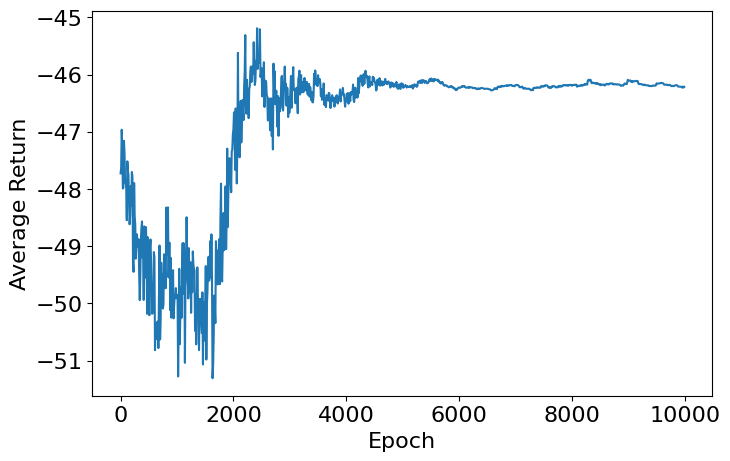

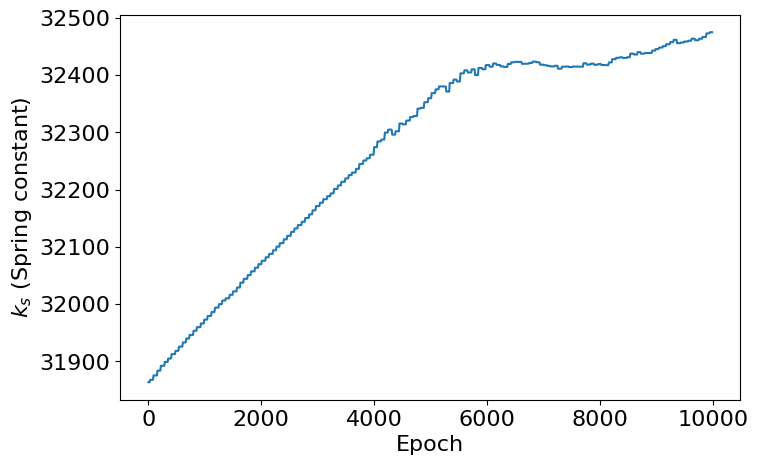

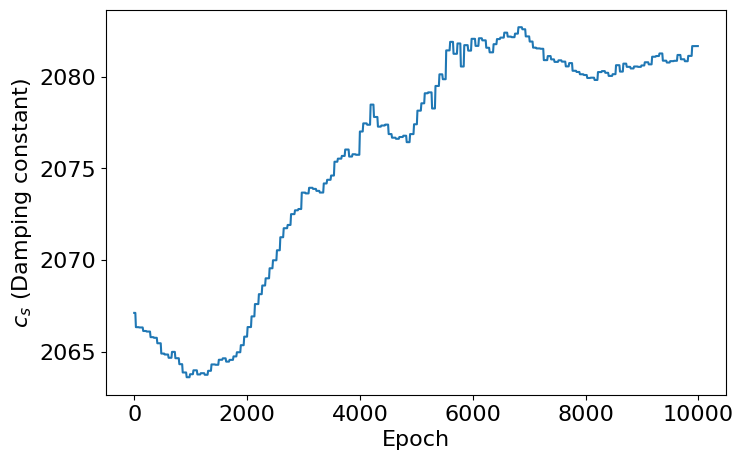

In [ ]:
import matplotlib.pyplot as plt

score_history_array = np.array(score_history).T
epoch = score_history_array[0,:]
score_history_array = score_history_array[1,:]
score_history_avg = score_history_array.reshape(-1, 10).mean(axis=1)

ks_history_array = np.array(ks_history).T
ks_history_array = ks_history_array[1,:]
cs_history_array = np.array(cs_history).T
cs_history_array = cs_history_array[1,:]

plt.figure(figsize=(8, 5))
plt.plot(epoch[::10], score_history_avg)
plt.tick_params(axis='both', labelsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Average Return', fontsize=16)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(epoch[::10], ks_history_array[::10])
plt.tick_params(axis='both', labelsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('$k_s$ (Spring constant)', fontsize=16)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(epoch[::10], cs_history_array[::10])
plt.tick_params(axis='both', labelsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('$c_s$ (Damping constant)', fontsize=16)
plt.show()


## Save the model trained after Generation 1 and Second CCD Optimization

CCD Optimization after learning the quantile and updating the digital model

In [ ]:
import pickle

variables_to_save = {
    'model2': model2,
    'ks_history_array': ks_history_array,
    'cs_history_array': cs_history_array,
    'score_history_array': score_history_array,
    'env2': env2,
    'score_history_avg': score_history_avg,
    # Add more variables as needed
}


with open('RL_PPO_susp_CCD_trained_second_model.pkl', 'wb') as file:
    pickle.dump(variables_to_save, file)

## Load the data

In [ ]:
import pickle

with open('RL_PPO_susp_CCD_trained_second_model.pkl', 'rb') as file:
    loaded_variables = pickle.load(file)

model2 = loaded_variables['model2']
ks_history_array = loaded_variables['ks_history_array']
cs_history_array = loaded_variables['cs_history_array']
score_history_array = loaded_variables['score_history_array']
env2 = loaded_variables['env2']
score_history_avg = loaded_variables['score_history_avg']


In [63]:
print(ks_history_array[-1])
print(cs_history_array[-1])


32510.91015625
2054.974853515625


## Evaluate the System after the Second CCD Optimization (Need to update the policy)

In [ ]:
import copy
ks = copy.deepcopy(ks_2) # after the first CCD optimization
cs = copy.deepcopy(cs_2) # after the first CCD optimization
ks_normalized = (ks-env.ks_min)/(env.ks_max-env.ks_min)
cs_normalized = (cs-env.cs_min)/(env.cs_max-env.cs_min)
xmin_array = xmin.numpy()
xmax_array = xmax.numpy()

print_interval = 10
rollout = []
score_history = []
N_total = 15000
score = 0.0
print_interval = 10
temp_training_data = []
training_len = 10
s = env.reset_origin(ks_normalized,cs_normalized)
done = False
count = 0
x_sys_gen2 = np.zeros((N_total+1,4))
a_sys_gen2 = np.zeros((N_total,))
x_sys_gen2[0,:] = np.array([s[0],s[1],s[2],s[3]])

while count < N_total:
    x_tmp = np.append(s,ks)
    x_tmp = np.append(x_tmp,cs)
    s_normalized = (s - xmin_array[0][0:4]) / (xmax_array[0][0:4] - xmin_array[0][0:4])
    x = (x_tmp - xmin_array[0]) / (xmax_array[0] - xmin_array[0])
    normalized_inputs_tmp = torch.tensor(x.reshape(1,6), dtype=torch.float32)
    mu, std = model2.pi(normalized_inputs_tmp)
    dist = Normal(mu, std)
    a = dist.sample()
    log_prob = dist.log_prob(a)
    action = min(max(a.item()*1000, env.action_space.low[0]), env.action_space.high[0])
    a_sys_gen2[count] = action
    s_prime, r, done, _ = env.step_real([action],dzdt[count],ks_normalized,cs_normalized)
    x_sys_gen2[count+1,:] = s_prime
    s_prime_normalized = (s_prime - xmin_array[0][0:4]) / (xmax_array[0][0:4] - xmin_array[0][0:4])
    rollout.append((s_normalized, action/1000, r/1000.0, s_prime_normalized, log_prob.item(), done))
    if len(rollout) == rollout_len:
        model2.put_data(rollout)
        rollout = []
        model2.train_net(ks,cs)

    s = s_prime

    score += r
    count += 1
    if count%print_interval==0:
        print("# of steps :{}, avg score : {:.4f}".format(count, score/print_interval))
        score = 0.0

env.close()

# of steps :10, avg score : -0.0334
# of steps :20, avg score : -0.0345
# of steps :30, avg score : -0.0342
# of steps :40, avg score : -0.0337
# of steps :50, avg score : -0.0334
# of steps :60, avg score : -0.0340
# of steps :70, avg score : -0.0349
# of steps :80, avg score : -0.0343
# of steps :90, avg score : -0.0340
# of steps :100, avg score : -0.0335
# of steps :110, avg score : -0.0354
# of steps :120, avg score : -0.0325
# of steps :130, avg score : -0.0357
# of steps :140, avg score : -0.0537
# of steps :150, avg score : -0.0410
# of steps :160, avg score : -0.0341
# of steps :170, avg score : -0.0356
# of steps :180, avg score : -0.0339
# of steps :190, avg score : -0.0347
# of steps :200, avg score : -0.0357
# of steps :210, avg score : -0.0344
# of steps :220, avg score : -0.0413
# of steps :230, avg score : -0.0328
# of steps :240, avg score : -0.0355
# of steps :250, avg score : -0.6383
# of steps :260, avg score : -0.9273
# of steps :270, avg score : -0.0346
# of steps

Return for Generation 1 : -2559.4382


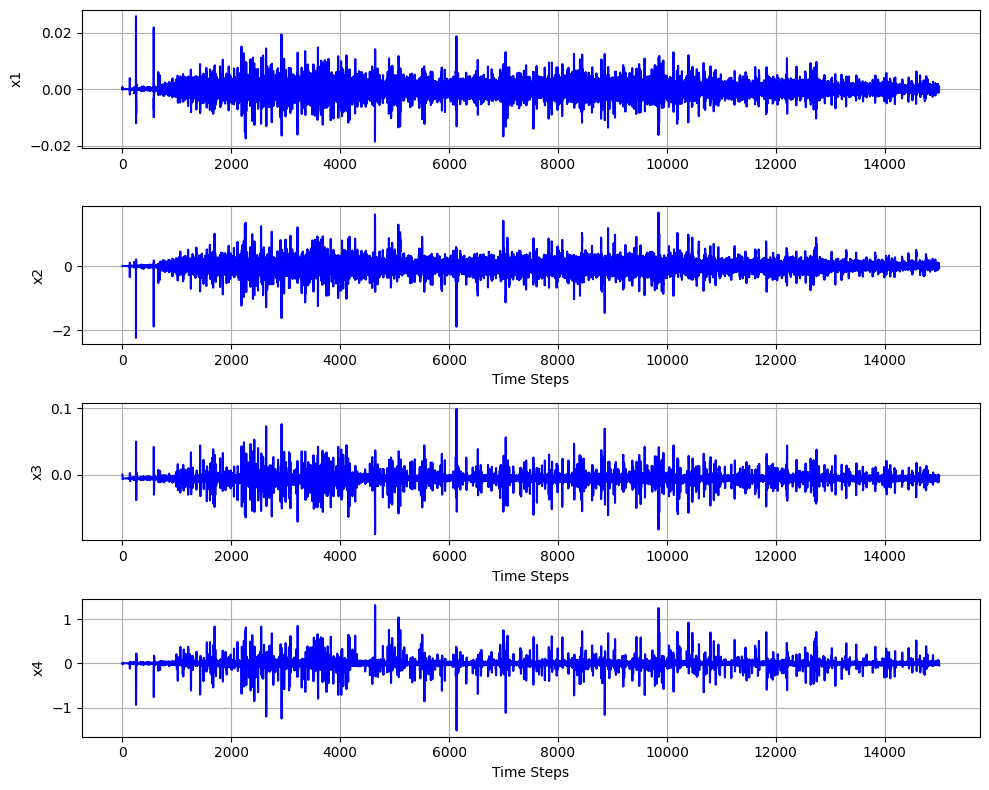

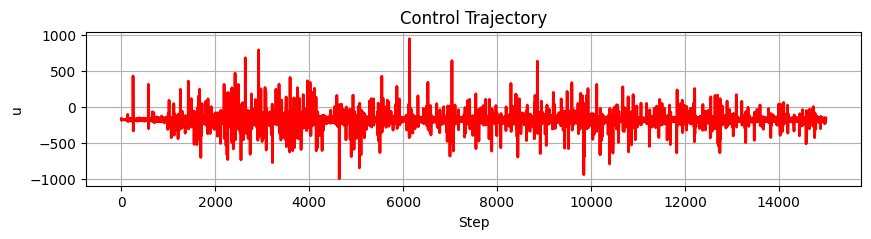

In [157]:
return_gen2 = 0
for i in range(1,15000):
    return_gen2 = return_gen2 - x_sys_gen2[i,:] @ env.Q @ x_sys_gen2[i,:].T - env.R * a_sys_gen2[i]**2
return_gen2 = return_gen2 - x_sys_gen2[-1,:] @ env.Q @ x_sys_gen2[-1,:].T
print("Return for Generation 1 : {:.4f}".format(return_gen2))

t_vec = np.arange(0, 15001)

# Create the mean trajectories with 95% confidence interval
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8))
ax1.plot(t_vec, x_sys_gen2[:,0], color='b', label='x1')
# ax1.set_xlabel('Time Steps')
ax1.set_ylabel('x1')
# ax1.set_ylim((-3.75,1.0))
# ax1.legend(loc='lower right')
ax1.grid(True)

ax2.plot(t_vec, x_sys_gen2[:,1], color='b', label='x2')
ax2.set_xlabel('Time Steps')
ax2.set_ylabel('x2')
# ax2.set_ylim((-4,2))
# ax2.legend(loc='lower right')
ax2.grid(True)


ax3.plot(t_vec, x_sys_gen2[:,2], color='b', label='x3')
ax3.set_xlabel('Time Steps')
ax3.set_ylabel('x3')
# ax3.set_ylim((-4,2))
# ax3.legend(loc='lower right')
ax3.grid(True)

ax4.plot(t_vec, x_sys_gen2[:,3], color='b', label='x4')
ax4.set_xlabel('Time Steps')
ax4.set_ylabel('x4')
# ax4.set_ylim((-4,2))
# ax4.legend(loc='lower right')
ax4.grid(True)

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 2))
plt.plot(t_vec[:-1], a_sys_gen2, label='u', color='r', linestyle='-', linewidth=2)

plt.title('Control Trajectory')
plt.xlabel('Step')
plt.ylabel('u')

plt.grid(True)
plt.show()

## Save data to CSV file

In [ ]:
import pandas as pd

data_to_save_csv = pd.DataFrame(x_sys_gen2)
data_to_save_csv.to_csv("x_sys_gen2.csv", index=False, header=False)

data_to_save_csv = pd.DataFrame(a_sys_gen2)
data_to_save_csv.to_csv("a_sys_gen2.csv", index=False, header=False)

## Try different initial conditions without noises

In [158]:
s_lower = np.array([-0.5, -2, -0.2, -1])
s_upper = np.array([0.5, 2, 0.2, 1])
N_samples = 200
s_samples = np.random.uniform(s_lower, s_upper, size=(N_samples, 4))
print(s_samples[0])

[-0.02991231 -0.78747138  0.03853491 -0.85791211]


In [164]:
ks = copy.deepcopy(ks_1) # after the first CCD optimization
cs = copy.deepcopy(cs_1) # after the first CCD optimization
ks_normalized = (ks-env.ks_min)/(env.ks_max-env.ks_min)
cs_normalized = (cs-env.cs_min)/(env.cs_max-env.cs_min)
xmin_array = xmin.numpy()
xmax_array = xmax.numpy()

score_history = []
N_total = 100
score = 0.0
return_gen1 = np.zeros(N_samples,)
for sample_idx in range(N_samples):
    s = s_samples[sample_idx]
    done = False
    count = 0
    x_sys_gen1 = np.zeros((N_total+1,4))
    a_sys_gen1 = np.zeros((N_total,))
    x_sys_gen1[0,:] = np.array([s[0],s[1],s[2],s[3]])

    while count < N_total:
        x_tmp = np.append(s,ks)
        x_tmp = np.append(x_tmp,cs)
        s_normalized = (s - xmin_array[0][0:4]) / (xmax_array[0][0:4] - xmin_array[0][0:4])
        x = (x_tmp - xmin_array[0]) / (xmax_array[0] - xmin_array[0])
        normalized_inputs_tmp = torch.tensor(x.reshape(1,6), dtype=torch.float32)
        mu, std = model.pi(normalized_inputs_tmp)
        dist = Normal(mu, std)
        a = dist.sample()
        log_prob = dist.log_prob(a)
        action = min(max(a.item()*1000, env.action_space.low[0]), env.action_space.high[0])
        a_sys_gen1[count] = action
        s_prime, r, done, _ = env.step_real([action],[0],ks_normalized,cs_normalized)
        x_sys_gen1[count+1,:] = s_prime

        s = s_prime

        score += r
        count += 1

    env.close()

    return_gen1_tmp = 0
    for i in range(1,100):
        return_gen1_tmp = return_gen1_tmp - x_sys_gen1[i,:] @ env.Q @ x_sys_gen1[i,:].T - env.R * a_sys_gen1[i]**2
    return_gen1_tmp = return_gen1_tmp - x_sys_gen1[-1,:] @ env.Q @ x_sys_gen1[-1,:].T
    return_gen1[sample_idx] = return_gen1_tmp



ks = copy.deepcopy(ks_2) # after the first CCD optimization
cs = copy.deepcopy(cs_2) # after the first CCD optimization
ks_normalized = (ks-env.ks_min)/(env.ks_max-env.ks_min)
cs_normalized = (cs-env.cs_min)/(env.cs_max-env.cs_min)
xmin_array = xmin.numpy()
xmax_array = xmax.numpy()

score_history = []
N_total = 100
score = 0.0
return_gen2 = np.zeros(N_samples,)
for sample_idx in range(N_samples):
    s = s_samples[sample_idx]
    done = False
    count = 0
    x_sys_gen2 = np.zeros((N_total+1,4))
    a_sys_gen2 = np.zeros((N_total,))
    x_sys_gen2[0,:] = np.array([s[0],s[1],s[2],s[3]])

    while count < N_total:
        x_tmp = np.append(s,ks)
        x_tmp = np.append(x_tmp,cs)
        s_normalized = (s - xmin_array[0][0:4]) / (xmax_array[0][0:4] - xmin_array[0][0:4])
        x = (x_tmp - xmin_array[0]) / (xmax_array[0] - xmin_array[0])
        normalized_inputs_tmp = torch.tensor(x.reshape(1,6), dtype=torch.float32)
        mu, std = model2.pi(normalized_inputs_tmp)
        dist = Normal(mu, std)
        a = dist.sample()
        log_prob = dist.log_prob(a)
        action = min(max(a.item()*1000, env.action_space.low[0]), env.action_space.high[0])
        a_sys_gen2[count] = action
        s_prime, r, done, _ = env.step_real([action],[0],ks_normalized,cs_normalized)
        x_sys_gen2[count+1,:] = s_prime

        s = s_prime

        score += r
        count += 1

    env.close()

    return_gen2_tmp = 0
    for i in range(1,100):
        return_gen2_tmp = return_gen2_tmp - x_sys_gen1[i,:] @ env.Q @ x_sys_gen2[i,:].T - env.R * a_sys_gen2[i]**2
    return_gen2_tmp = return_gen2_tmp - x_sys_gen2[-1,:] @ env.Q @ x_sys_gen2[-1,:].T
    return_gen2[sample_idx] = return_gen2_tmp

In [165]:
import pandas as pd

data_to_save_csv = pd.DataFrame(return_gen1)
data_to_save_csv.to_csv("return_gen1.csv", index=False, header=False)

data_to_save_csv = pd.DataFrame(return_gen2)
data_to_save_csv.to_csv("return_gen2.csv", index=False, header=False)

In [287]:
import copy

ks = copy.deepcopy(ks_1) # after the first CCD optimization
cs = copy.deepcopy(cs_1) # after the first CCD optimization
ks_normalized = (ks-env.ks_min)/(env.ks_max-env.ks_min)
cs_normalized = (cs-env.cs_min)/(env.cs_max-env.cs_min)
xmin_array = xmin.numpy()
xmax_array = xmax.numpy()

score_history = []
N_total = 100
score = 0.0
temp_training_data = []
training_len = 10
# s = np.array([0.1,2,-1,-2.5])
s = s_samples[1]

done = False
count = 0
x_sys_gen1 = np.zeros((N_total+1,4))
a_sys_gen1 = np.zeros((N_total,))
x_sys_gen1[0,:] = np.array([s[0],s[1],s[2],s[3]])

while count < N_total:
    x_tmp = np.append(s,ks)
    x_tmp = np.append(x_tmp,cs)
    s_normalized = (s - xmin_array[0][0:4]) / (xmax_array[0][0:4] - xmin_array[0][0:4])
    x = (x_tmp - xmin_array[0]) / (xmax_array[0] - xmin_array[0])
    normalized_inputs_tmp = torch.tensor(x.reshape(1,6), dtype=torch.float32)
    mu, std = model.pi(normalized_inputs_tmp)
    dist = Normal(mu, std)
    a = dist.sample()
    log_prob = dist.log_prob(a)
    action = min(max(a.item()*1000, env.action_space.low[0]), env.action_space.high[0])
    a_sys_gen1[count] = action
    s_prime, r, done, _ = env.step_real([action],[0],ks_normalized,cs_normalized)
    x_sys_gen1[count+1,:] = s_prime

    s = s_prime

    score += r
    count += 1

env.close()


ks = copy.deepcopy(ks_2) # after the first CCD optimization
cs = copy.deepcopy(cs_2) # after the first CCD optimization
ks_normalized = (ks-env.ks_min)/(env.ks_max-env.ks_min)
cs_normalized = (cs-env.cs_min)/(env.cs_max-env.cs_min)
xmin_array = xmin.numpy()
xmax_array = xmax.numpy()

N_total = 100
score = 0.0
temp_training_data = []
training_len = 10
# s = np.array([0.1,2,-1,-2.5])
s = s_samples[1]

done = False
count = 0
x_sys_gen2 = np.zeros((N_total+1,4))
a_sys_gen2 = np.zeros((N_total,))
x_sys_gen2[0,:] = np.array([s[0],s[1],s[2],s[3]])

while count < N_total:
    x_tmp = np.append(s,ks)
    x_tmp = np.append(x_tmp,cs)
    s_normalized = (s - xmin_array[0][0:4]) / (xmax_array[0][0:4] - xmin_array[0][0:4])
    x = (x_tmp - xmin_array[0]) / (xmax_array[0] - xmin_array[0])
    normalized_inputs_tmp = torch.tensor(x.reshape(1,6), dtype=torch.float32)
    mu, std = model2.pi(normalized_inputs_tmp)
    dist = Normal(mu, std)
    a = dist.sample()
    log_prob = dist.log_prob(a)
    action = min(max(a.item()*1000, env.action_space.low[0]), env.action_space.high[0])
    a_sys_gen2[count] = action
    s_prime, r, done, _ = env.step_real([action],[0],ks_normalized,cs_normalized)
    x_sys_gen2[count+1,:] = s_prime

    s = s_prime

    score += r
    count += 1

env.close()

Return for Generation 1 : -5.6722


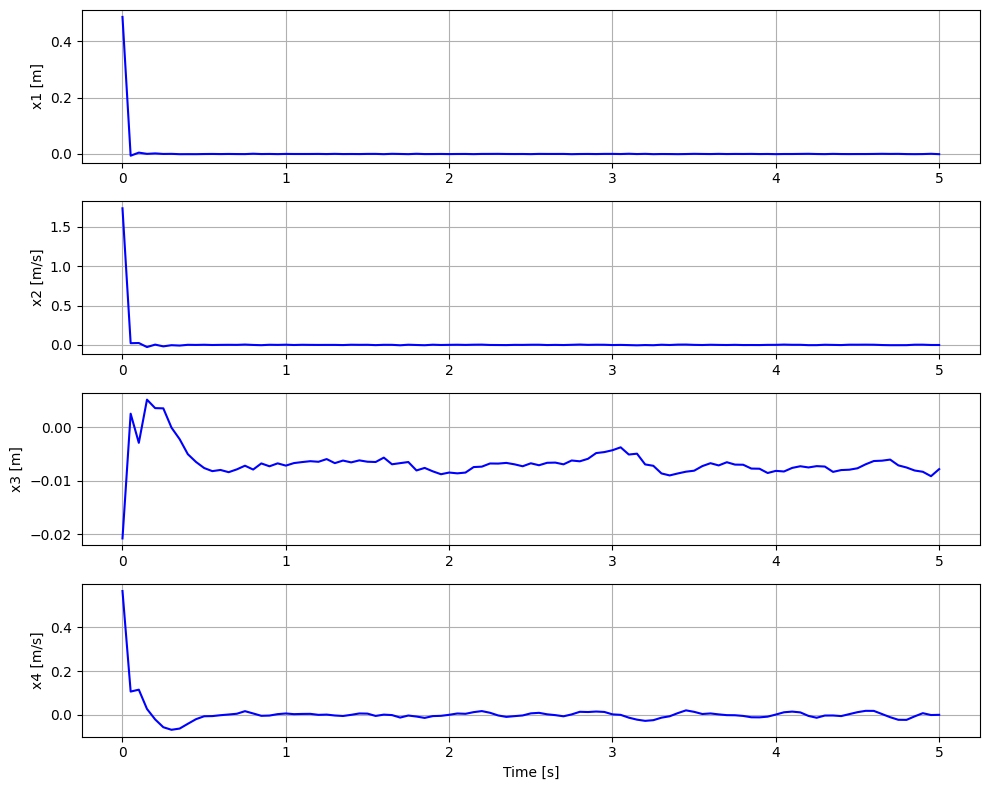

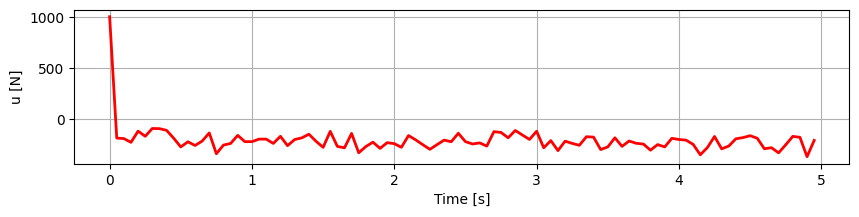

Return for Generation 2 : -3.5529


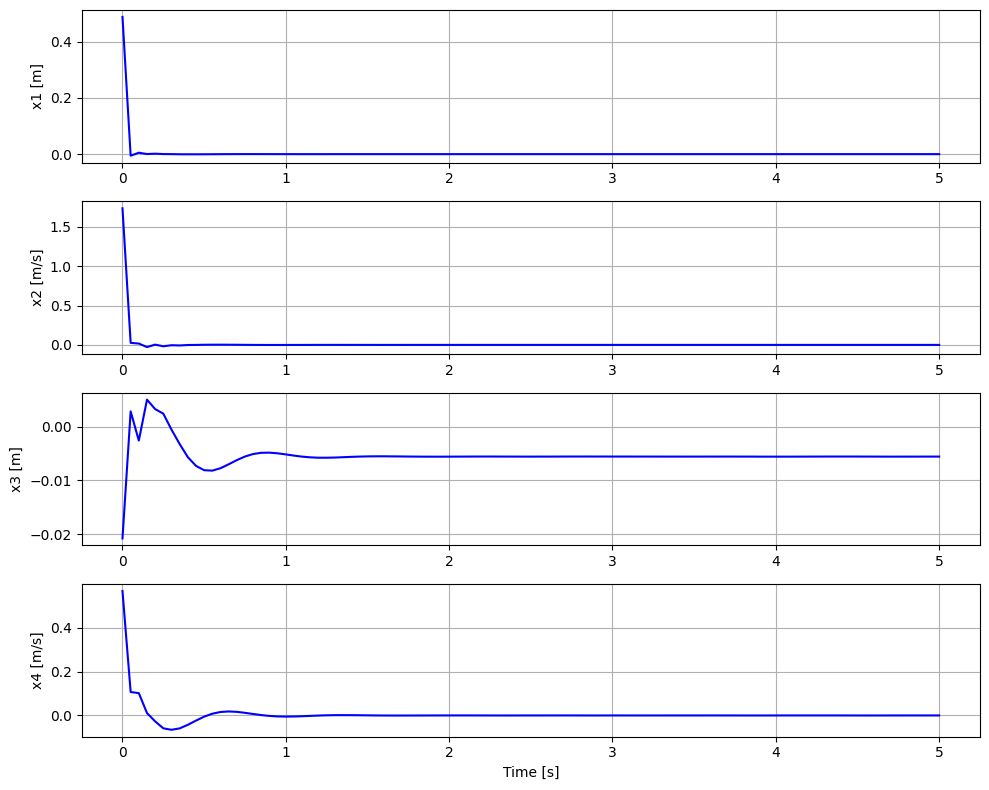

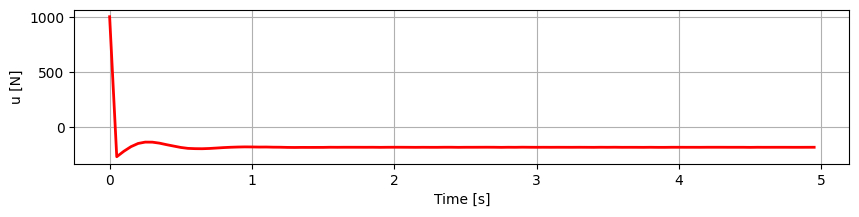

In [162]:
return_gen1 = 0
for i in range(1,100):
    return_gen1 = return_gen1 - x_sys_gen1[i,:] @ env.Q @ x_sys_gen1[i,:].T - env.R * a_sys_gen1[i]**2
return_gen1 = return_gen1 - x_sys_gen1[-1,:] @ env.Q @ x_sys_gen1[-1,:].T
print("Return for Generation 1 : {:.4f}".format(return_gen1))

t_vec = np.arange(0, 101)*0.05

# Create the mean trajectories with 95% confidence interval
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8))
ax1.plot(t_vec, x_sys_gen1[:,0], color='b', label='x1')
ax1.set_ylabel('x1 [m]')
ax1.grid(True)

ax2.plot(t_vec, x_sys_gen1[:,1], color='b', label='x2')
ax2.set_ylabel('x2 [m/s]')
ax2.grid(True)


ax3.plot(t_vec, x_sys_gen1[:,2], color='b', label='x3')
ax3.set_ylabel('x3 [m]')
ax3.grid(True)

ax4.plot(t_vec, x_sys_gen1[:,3], color='b', label='x4')
ax4.set_xlabel('Time [s]')
ax4.set_ylabel('x4 [m/s]')
ax4.grid(True)

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 2))
plt.plot(t_vec[:-1], a_sys_gen1, label='u', color='r', linestyle='-', linewidth=2)
plt.xlabel('Time [s]')
plt.ylabel('u [N]')
# plt.ylim((-1000,-100))

plt.grid(True)
plt.show()


return_gen2 = 0
for i in range(1,100):
    return_gen2 = return_gen2 - x_sys_gen2[i,:] @ env.Q @ x_sys_gen2[i,:].T - env.R * a_sys_gen2[i]**2
return_gen2 = return_gen2 - x_sys_gen2[-1,:] @ env.Q @ x_sys_gen2[-1,:].T
print("Return for Generation 2 : {:.4f}".format(return_gen2))


# Create the mean trajectories with 95% confidence interval
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8))
ax1.plot(t_vec, x_sys_gen2[:,0], color='b', label='x1')
ax1.set_ylabel('x1 [m]')
ax1.grid(True)

ax2.plot(t_vec, x_sys_gen2[:,1], color='b', label='x2')
ax2.set_ylabel('x2 [m/s]')
ax2.grid(True)


ax3.plot(t_vec, x_sys_gen2[:,2], color='b', label='x3')
ax3.set_ylabel('x3 [m]')
ax3.grid(True)

ax4.plot(t_vec, x_sys_gen2[:,3], color='b', label='x4')
ax4.set_xlabel('Time [s]')
ax4.set_ylabel('x4 [m/s]')
ax4.grid(True)

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 2))
plt.plot(t_vec[:-1], a_sys_gen2, label='u', color='r', linestyle='-', linewidth=2)
plt.xlabel('Time [s]')
plt.ylabel('u [N]')
# plt.ylim((-1000,-100))

plt.grid(True)
plt.show()

## Save data into CSV

In [163]:
import pandas as pd

data_to_save_csv = pd.DataFrame(x_sys_gen1)
data_to_save_csv.to_csv("x_sys_gen1_trial1.csv", index=False, header=False)

data_to_save_csv = pd.DataFrame(a_sys_gen1)
data_to_save_csv.to_csv("a_sys_gen1_trial1.csv", index=False, header=False)

data_to_save_csv = pd.DataFrame(x_sys_gen2)
data_to_save_csv.to_csv("x_sys_gen2_trial1.csv", index=False, header=False)

data_to_save_csv = pd.DataFrame(a_sys_gen2)
data_to_save_csv.to_csv("a_sys_gen2_trial1.csv", index=False, header=False)